# Create a machine learning model to achive the prevision of the time after a certain amout of time

import libraries


In [351]:
# install Thorch
#!pip install torch

In [352]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import tensorflow as tf
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from datetime import timedelta
from tensorflow.keras.regularizers import l2
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

To set the correct gender, uncomment the code below

In [353]:
# upload dataset (standard female o male) uncomment/comment

train_data_path = "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_female_final.csv"
#train_data_path = "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_male_final.csv"

In [354]:
# open file
train_df = pd.read_csv(train_data_path, low_memory=False)
train_df.dtypes

date_of_event      int64
event_date        object
position           int64
swim_time          int64
T1_time            int64
bike_time          int64
T2_time            int64
run_time           int64
total_time         int64
swim_position    float64
t1_position      float64
bike_position    float64
t2_position      float64
run_position     float64
dtype: object

In [355]:
train_df.tail()

date_of_event  event_date  position  swim_time  T1_time  bike_time  \
37122           2024  25/05/2024        44       1216       46       3368   
37123           2024  25/05/2024        45       1213       47       3371   
37124           2024  25/05/2024        46       1182       45       3405   
37125           2024  25/05/2024        47       1187       46       3399   
37126           2024  25/05/2024        48       1201       47       3382   

       T2_time  run_time  total_time  swim_position  t1_position  \
37122       23      2202        6853           46.0         20.0   
37123       26      2285        6939           45.0         29.0   
37124       29      2304        6962           31.0         11.0   
37125       25      2333        6988           33.0         18.0   
37126       25      2365        7018           41.0         27.0   

       bike_position  t2_position  run_position  
37122           28.0         13.0          43.0  
37123           31.0         36.0          45.0  
37124           43.0         46.0          46.0  
37125           41.0         33.0          47.0  
37126           32.0         32.0          48.0

In [356]:
train_df.head()

date_of_event  event_date  position  swim_time  T1_time  bike_time  \
0           1985  27/07/1985         1       1247        0       6081   
1           1986  22/06/1986         4          0        0          0   
2           1986  22/06/1986         1          0        0          0   
3           1986  22/06/1986         2          0        0          0   
4           1986  22/06/1986         3          0        0          0   

   T2_time  run_time  total_time  swim_position  t1_position  bike_position  \
0        0      2950       10278            2.0          1.0            1.0   
1        0         0        8550            1.0          1.0            1.0   
2        0         0        8220            2.0          2.0            2.0   
3        0         0        8320            3.0          3.0            3.0   
4        0         0        8510            4.0          4.0            4.0   

   t2_position  run_position  
0          1.0           2.0  
1          1.0           1.0  
2          2.0           2.0  
3          3.0           3.0  
4          4.0           4.0

Visualize dataset in a scatter chart to undestand the final position and the time

<ipython-input-357-ff0d1b78a4f8>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_df['event_date'] = pd.to_datetime(train_df['event_date'])


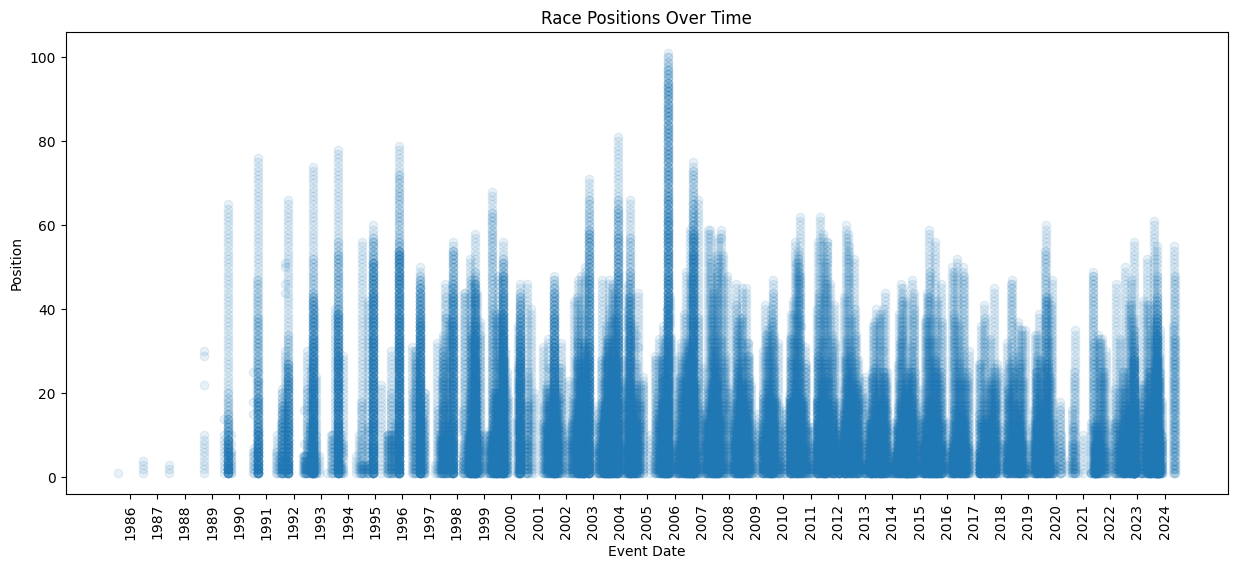

In [357]:
# Convert 'event_date' in datetime
train_df['event_date'] = pd.to_datetime(train_df['event_date'])

# sort DataFrame previously for 'event_date' and then for 'position'
df_sorted = train_df.sort_values(by=['event_date', 'position'])

# make a scatter plot
plt.figure(figsize=(15, 6))

years = pd.date_range(start=df_sorted['event_date'].min(),
                      end=df_sorted['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

plt.scatter(df_sorted['event_date'], df_sorted['position'], alpha=0.1)
plt.title('Race Positions Over Time')
plt.xlabel('Event Date')
plt.ylabel('Position')

plt.show()

During the data cleaning in the previous notebook, some race are cutted for the position. a time below 2500 seconds are deleted from the dataset
In this chart we visualize the race with no firs, second or third position
We can observe that the race previously the 1996 it's not important for the analysis:
- delete all the race before 1989/01/01/
- delete all the race without the first, second and third position

In [358]:
# Specify the cutoff date
cutoff_date = '1989-01-01'

# Filter the DataFrame to remove rows before the cutoff date
df_sorted = df_sorted.loc[df_sorted['event_date'] >= cutoff_date]
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

date_of_event event_date  position  swim_time  T1_time  bike_time  \
0               1989 1989-06-11         1       1400        0       4483   
1               1989 1989-06-11         2       1380        0       4658   
2               1989 1989-06-11         3       1482        0       4665   
3               1989 1989-06-11         4       1546        0       4643   
4               1989 1989-06-11         5       1629        0       4567   
...              ...        ...       ...        ...      ...        ...   
37101           2024 2024-05-25        44       1216       46       3368   
37102           2024 2024-05-25        45       1213       47       3371   
37103           2024 2024-05-25        46       1182       45       3405   
37104           2024 2024-05-25        47       1187       46       3399   
37105           2024 2024-05-25        48       1201       47       3382   

       T2_time  run_time  total_time  swim_position  t1_position  \
0            0      2335        8219            3.0          1.0   
1            0      2497        8537            2.0          2.0   
2            0      2408        8556            6.0          3.0   
3            0      2376        8564            8.0          4.0   
4            0      2377        8574           10.0          5.0   
...        ...       ...         ...            ...          ...   
37101       23      2202        6853           46.0         20.0   
37102       26      2285        6939           45.0         29.0   
37103       29      2304        6962           31.0         11.0   
37104       25      2333        6988           33.0         18.0   
37105       25      2365        7018           41.0         27.0   

       bike_position  t2_position  run_position  
0                2.0          1.0           2.0  
1                6.0          2.0          11.0  
2                7.0          3.0           6.0  
3                5.0          4.0           3.0  
4                3.0          5.0           4.0  
...              ...          ...           ...  
37101           28.0         13.0          43.0  
37102           31.0         36.0          45.0  
37103           43.0         46.0          46.0  
37104           41.0         33.0          47.0  
37105           32.0         32.0          48.0  

[37106 rows x 14 columns]

In [359]:
# Some information
length = len(df_sorted)
unique_race = len(df_sorted["event_date"].unique())
race_date = df_sorted["event_date"].unique().strftime('%Y-%m-%d')

print(f"Total row = {length}")
print(f"Total race is = {unique_race}")
print(f"Race date from {race_date[0]} to {race_date[-1]}")

Total row = 37106
Total race is = 1259
Race date from 1989-06-11 to 2024-05-25


In [360]:
# Group by year and event_date, then count the occurrences
df_sorted['date_of_event'] = df_sorted['date_of_event'].astype(int)
date_counts = df_sorted.groupby(['date_of_event', 'event_date']).size().reset_index(name='count')

# Filter to only keep dates that are repeated (i.e., count > 1)
repeated_dates = date_counts[date_counts['count'] > 1]

# Count the number of repeated dates for each year
repeated_dates_per_year = repeated_dates.groupby('date_of_event').size()

# Display the result
print(repeated_dates_per_year)

date_of_event
1989     3
1990     4
1991    13
1992    23
1993    12
1994    14
1995    13
1996    13
1997    25
1998    34
1999    44
2000    14
2001    33
2002    41
2003    57
2004    37
2005    36
2006    53
2007    47
2008    49
2009    44
2010    49
2011    50
2012    46
2013    55
2014    63
2015    55
2016    49
2017    43
2018    43
2019    50
2020    10
2021    27
2022    43
2023    48
2024     4
dtype: int64


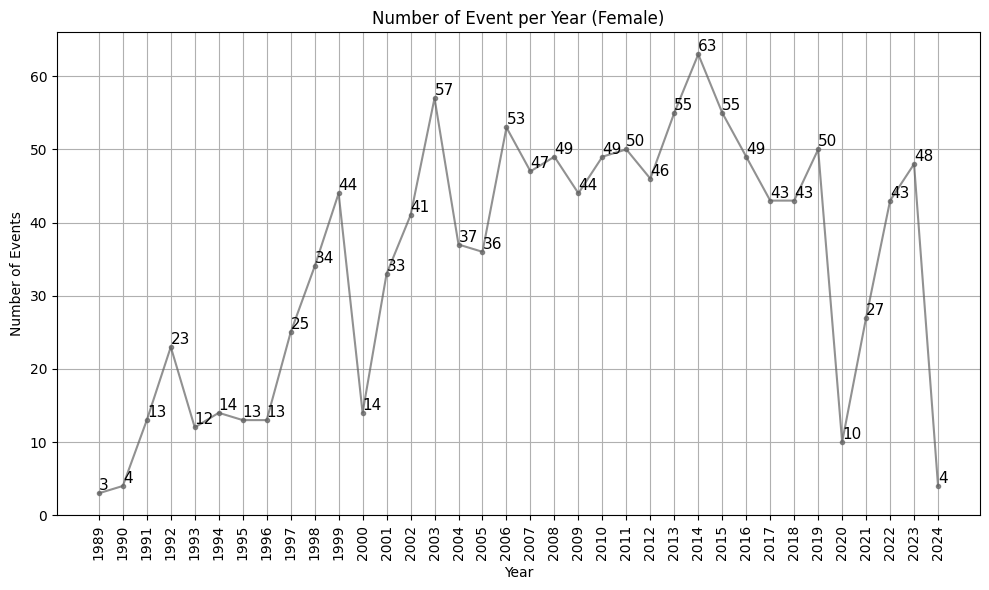

In [361]:
# plot data
file_female= "/content/drive/MyDrive/TRIATHLON ANALYSIS/db_standard_female_final.csv"
if train_data_path == file_female:
  sex = "(Female)"
else:
  sex = "(Male)"


plt.figure(figsize=(10, 6))

repeated_dates_per_year.plot(kind='line', marker='.', color="#626262", alpha=0.7)
plt.title(f"Number of Event per Year {sex}")
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.xticks(ticks=repeated_dates_per_year.index, labels=repeated_dates_per_year.index, rotation=90)
plt.grid(True)

for x, y in zip(repeated_dates_per_year.index, repeated_dates_per_year):
    plt.text(int(x), y, str(y), ha="left", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()


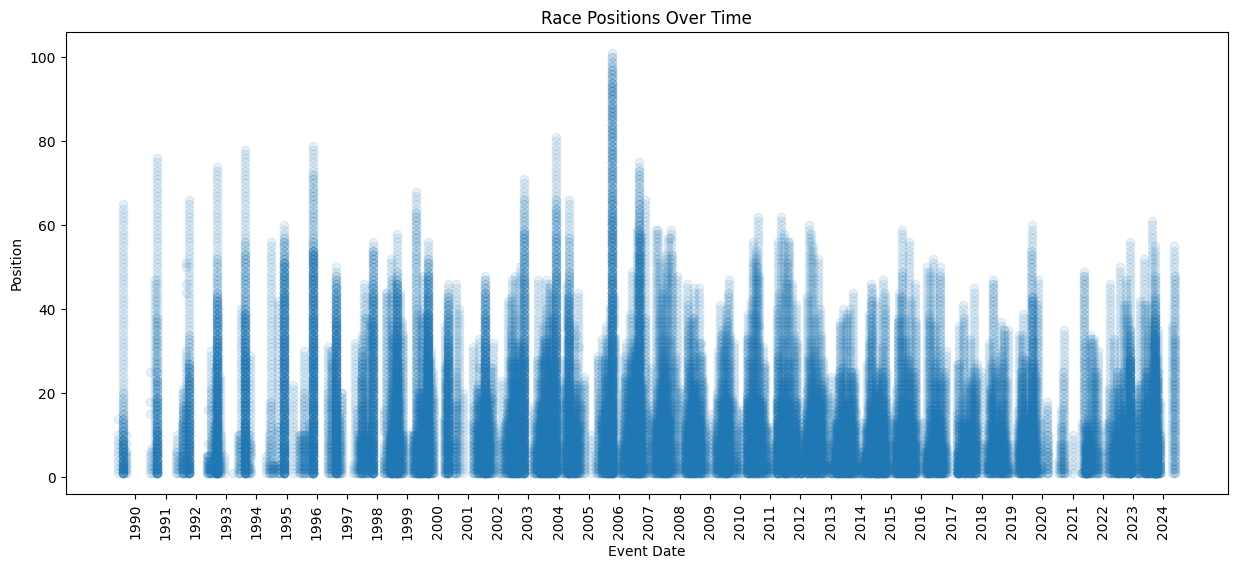

In [362]:
# make a scatter plot to conferm the cutting date
plt.figure(figsize=(15, 6))

years = pd.date_range(start=df_sorted['event_date'].min(),
                      end=df_sorted['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

plt.scatter(df_sorted['event_date'], df_sorted['position'], alpha=0.1)
plt.title('Race Positions Over Time')
plt.xlabel('Event Date')
plt.ylabel('Position')

plt.show()

In [363]:
# Supponendo che 'df_sorted' sia il DataFrame iniziale con i dati ordinati
def filter_races_with_positions(df, position_col='position', event_col='event_date'):
    # Lista degli eventi da mantenere (quelli che hanno le posizioni 1, 2 e 3)
    valid_events = []

    # Raggruppa per 'event_date'
    for date, group in df.groupby(event_col):
        # Verifica se tutte le posizioni 1, 2, e 3 sono presenti
        if all(pos in group[position_col].values for pos in [1, 2, 3]):
            valid_events.append(date)

    # Filtra il DataFrame mantenendo solo gli eventi con tutte le posizioni 1, 2 e 3
    filtered_df = df[df[event_col].isin(valid_events)]

    return filtered_df

# Applica la funzione al DataFrame
df_filtered = filter_races_with_positions(df_sorted)

# Verifica il risultato
print(f"Numero di eventi originali: {df_sorted['event_date'].nunique()}")
print(f"Numero di eventi dopo il filtro: {df_filtered['event_date'].nunique()}")

# Se necessario, procedi con le operazioni di calcolo su 'df_filtered'

Numero di eventi originali: 1259
Numero di eventi dopo il filtro: 1226


To have correct data also in the test dataset, visualize the position and the date for the test dataset

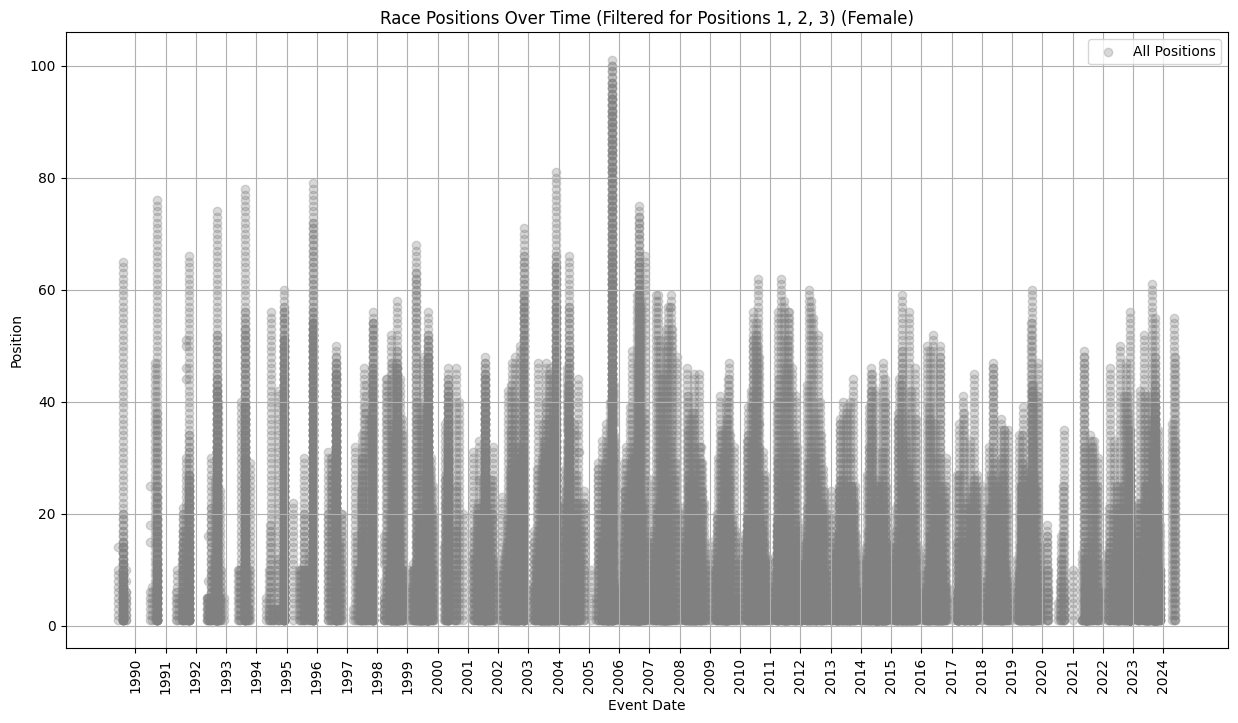

In [364]:
# Supponiamo che df_filtered sia il DataFrame filtrato in base alla presenza delle posizioni 1, 2 e 3
plt.figure(figsize=(15, 8))

# Grafico di tutte le posizioni nel DataFrame filtrato
plt.scatter(df_filtered['event_date'], df_filtered['position'], color='gray', label='All Positions', alpha=0.3)

# Impostazioni per l'asse x
years = pd.date_range(start=df_filtered['event_date'].min(),
                      end=df_filtered['event_date'].max(),
                      freq='YS')

plt.xticks(years.to_pydatetime(), years.year, rotation=90)

# Impostazioni del grafico
plt.title(f'Race Positions Over Time (Filtered for Positions 1, 2, 3) {sex}')
plt.xlabel('Event Date')
plt.ylabel('Position')
# plt.gca().invert_yaxis()  # Se vuoi invertire l'asse y
# plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)
plt.show()

We need to check if the data have not duplicates or null row for train and test dataset

In [365]:
# Check for duplicates for train dataset
duplicates = train_df.duplicated()
if duplicates.any():
    print("Found duplicates. Removing...")
    # Remove duplicates
    df_final_train = train_df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# Check for missing data in any row
missing_data = train_df.isnull().any(axis=1)
if missing_data.any():
    print(f"Found rows with missing data. Removing {missing_data.sum()} rows...")
    # Remove rows with missing data
    train_df = train_df.dropna()
    print("Rows with missing data removed.")
else:
    print("No missing data found.")

Found duplicates. Removing...
Duplicates removed.
No missing data found.


In [366]:
# Funzione per creare il dataframe 'top3'
def create_top3_structure(df, event_col, swim_col, bike_col, run_col, total_time_col, position_col):
    # Filtra per le prime 3 posizioni per ogni evento
    top3_df = df[df[position_col] <= 3].sort_values(by=[event_col, position_col]).groupby(event_col).head(3)

    # Seleziona solo le colonne necessarie
    top3_df = top3_df[[event_col, swim_col, bike_col, run_col, total_time_col]]

    return top3_df

# Applica la funzione ai dati filtrati
train_df_top3 = create_top3_structure(df_filtered, 'event_date', 'swim_time', 'bike_time', 'run_time', 'total_time', 'position')

# Verifica se i due dataset hanno la stessa lunghezza e le stesse colonne
print(f"Lunghezza top3: {len(train_df_top3)}")
print(f"Colonne top3: {train_df_top3.columns.tolist()}")

# Mostra le prime righe di ciascun dataset per verifica
print(train_df_top3.head())



Lunghezza top3: 3678
Colonne top3: ['event_date', 'swim_time', 'bike_time', 'run_time', 'total_time']
   event_date  swim_time  bike_time  run_time  total_time
0  1989-06-11       1400       4483      2335        8219
1  1989-06-11       1380       4658      2497        8537
2  1989-06-11       1482       4665      2408        8556
11 1989-08-06       1771       3786      2244        7800
12 1989-08-06       1745       4158      2664        8569


In [367]:
# big_chart function to use any dataframe passed as an argument

def big_chart(df, df_name):

    # Convert date to datetime if not already done
    df.loc[:, 'event_date'] = pd.to_datetime(df['event_date'])

    years = pd.date_range(start=df['event_date'].min(),
                          end=df['event_date'].max(),
                          freq='YS')

    # Calculate mean and standard deviation
    mean_swim = df['swim_time'].mean()
    std_swim = df['swim_time'].std() * 2

    mean_bike = df['bike_time'].mean()
    std_bike = df['bike_time'].std() * 2

    mean_run = df['run_time'].mean()
    std_run = df['run_time'].std() * 2

    mean_total = df['total_time'].mean()
    std_total = df['total_time'].std() * 2

    # Make a chart for the data
    plt.figure(figsize=(20, 12))

    plt.subplot(4, 1, 1)
    plt.scatter(df['event_date'], df['swim_time'], label='Swim Time', color='blue', alpha=0.3)
    plt.axhline(mean_swim, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_swim + std_swim, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_swim - std_swim, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Swim Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    plt.ylim(0, 2500)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.scatter(df['event_date'], df['bike_time'], label='Bike Time', color='green', alpha=0.3)
    plt.axhline(mean_bike, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_bike + std_bike, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_bike - std_bike, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Bike Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    plt.ylim(0, 6500)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.scatter(df['event_date'], df['run_time'], label='Run Time', color='red', alpha=0.3)
    plt.axhline(mean_run, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_run + std_run, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_run - std_run, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Run Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    plt.ylim(0, 4000)
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.scatter(df['event_date'], df['total_time'], label='Total Time', color='purple', alpha=0.3)
    plt.axhline(mean_total, color='orange', linestyle='dashed', linewidth=2, label='Mean')
    plt.axhline(mean_total + std_total, color='red', linestyle='dotted', linewidth=2, label='Std Dev')
    plt.axhline(mean_total - std_total, color='red', linestyle='dotted', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{df_name} Total Time {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    plt.ylim(3600, 8000)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use the big_chart function with different dataframes


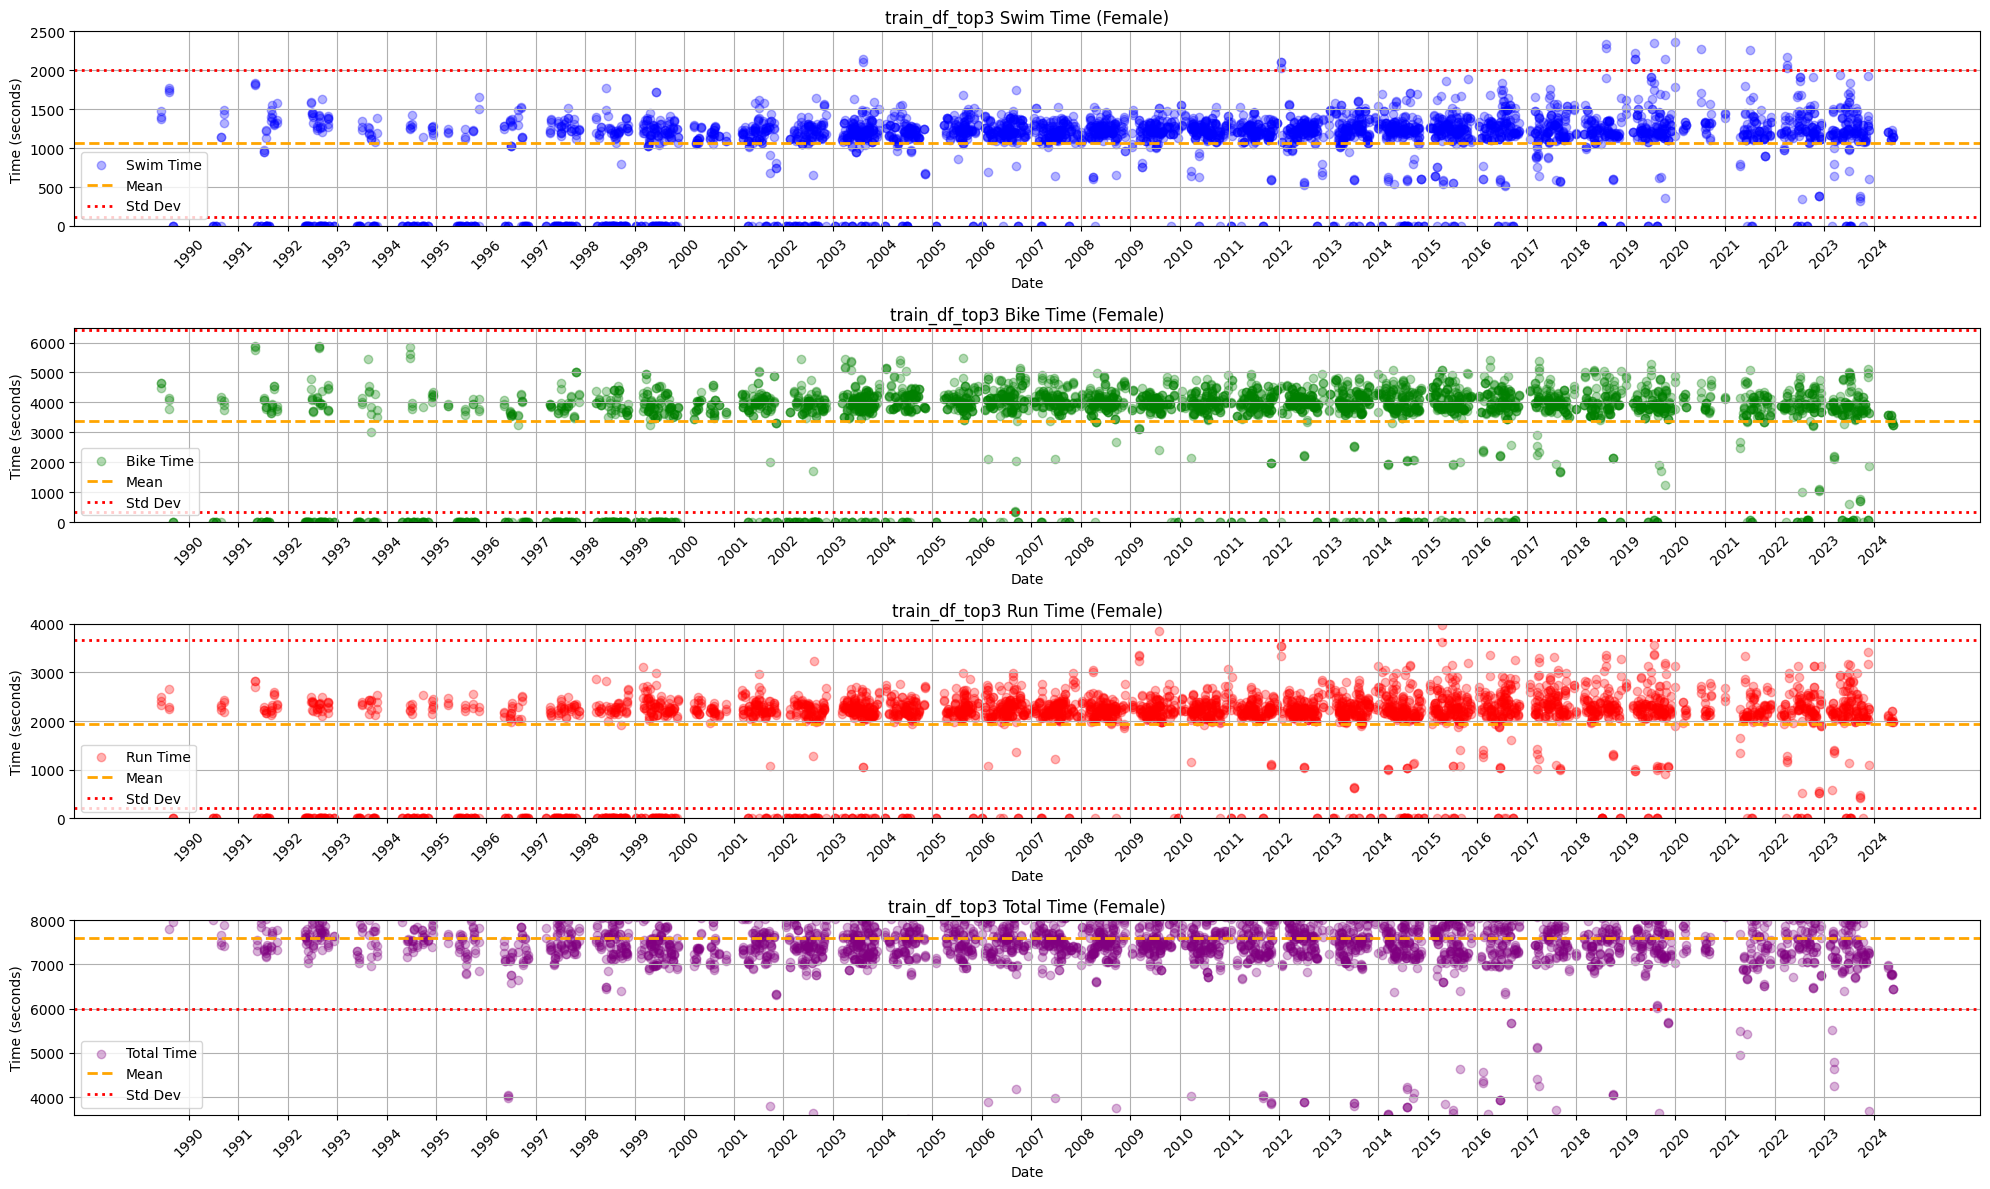

In [368]:
big_chart(train_df_top3, "train_df_top3")

All data are clean.


# Prepare the data for the machine learning model

Extract data from the first 3 position for every race in train and test dataframe.

If you want to change the range (for example the first 5 position) set 5 like a range (the variable it isn't important to change)

Create a chart data from the train and test data

Probably there's much zero in a data

In [369]:
# Function to create lag features
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df

# Assuming train_df_top3 is already defined and has the required columns
# Convert date to datetime
train_df_top3['event_date'] = pd.to_datetime(train_df_top3['event_date'])

# Define lags
lags = [1, 2, 3]

# Create lag variables for each column in the train set
for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
    train_df_top3 = create_lag_features(train_df_top3, lags, col)

# Remove rows with NaN and zero values in the train set
columns_to_check = ['swim_time', 'bike_time', 'run_time', 'total_time']
train_df_top3 = train_df_top3.dropna()
train_df_top3 = train_df_top3[(train_df_top3[columns_to_check] != 0).all(axis=1)]
train_df_top3 = train_df_top3.dropna(subset=columns_to_check)

# Calculate mean and standard deviation for swim, bike, and run times
mean_swim = train_df_top3['swim_time'].mean()
std_swim = train_df_top3['swim_time'].std()

mean_bike = train_df_top3['bike_time'].mean()
std_bike = train_df_top3['bike_time'].std()

mean_run = train_df_top3['run_time'].mean()
std_run = train_df_top3['run_time'].std()

# Filter data to keep rows within 2 standard deviations from the mean
filtered_df = train_df_top3[
    (train_df_top3['swim_time'] >= mean_swim - 2 * std_swim) & (train_df_top3['swim_time'] <= mean_swim + 2 * std_swim) &
    (train_df_top3['bike_time'] >= mean_bike - 2 * std_bike) & (train_df_top3['bike_time'] <= mean_bike + 2 * std_bike) &
    (train_df_top3['run_time'] >= mean_run - 2 * std_run) & (train_df_top3['run_time'] <= mean_run + 2 * std_run)
].copy()

# Print the number of rows before and after filtering
print(f"Number of rows before filtering: {train_df_top3.shape[0]}")
print(f"Number of rows after filtering: {filtered_df.shape[0]}")


Number of rows before filtering: 3116
Number of rows after filtering: 2841


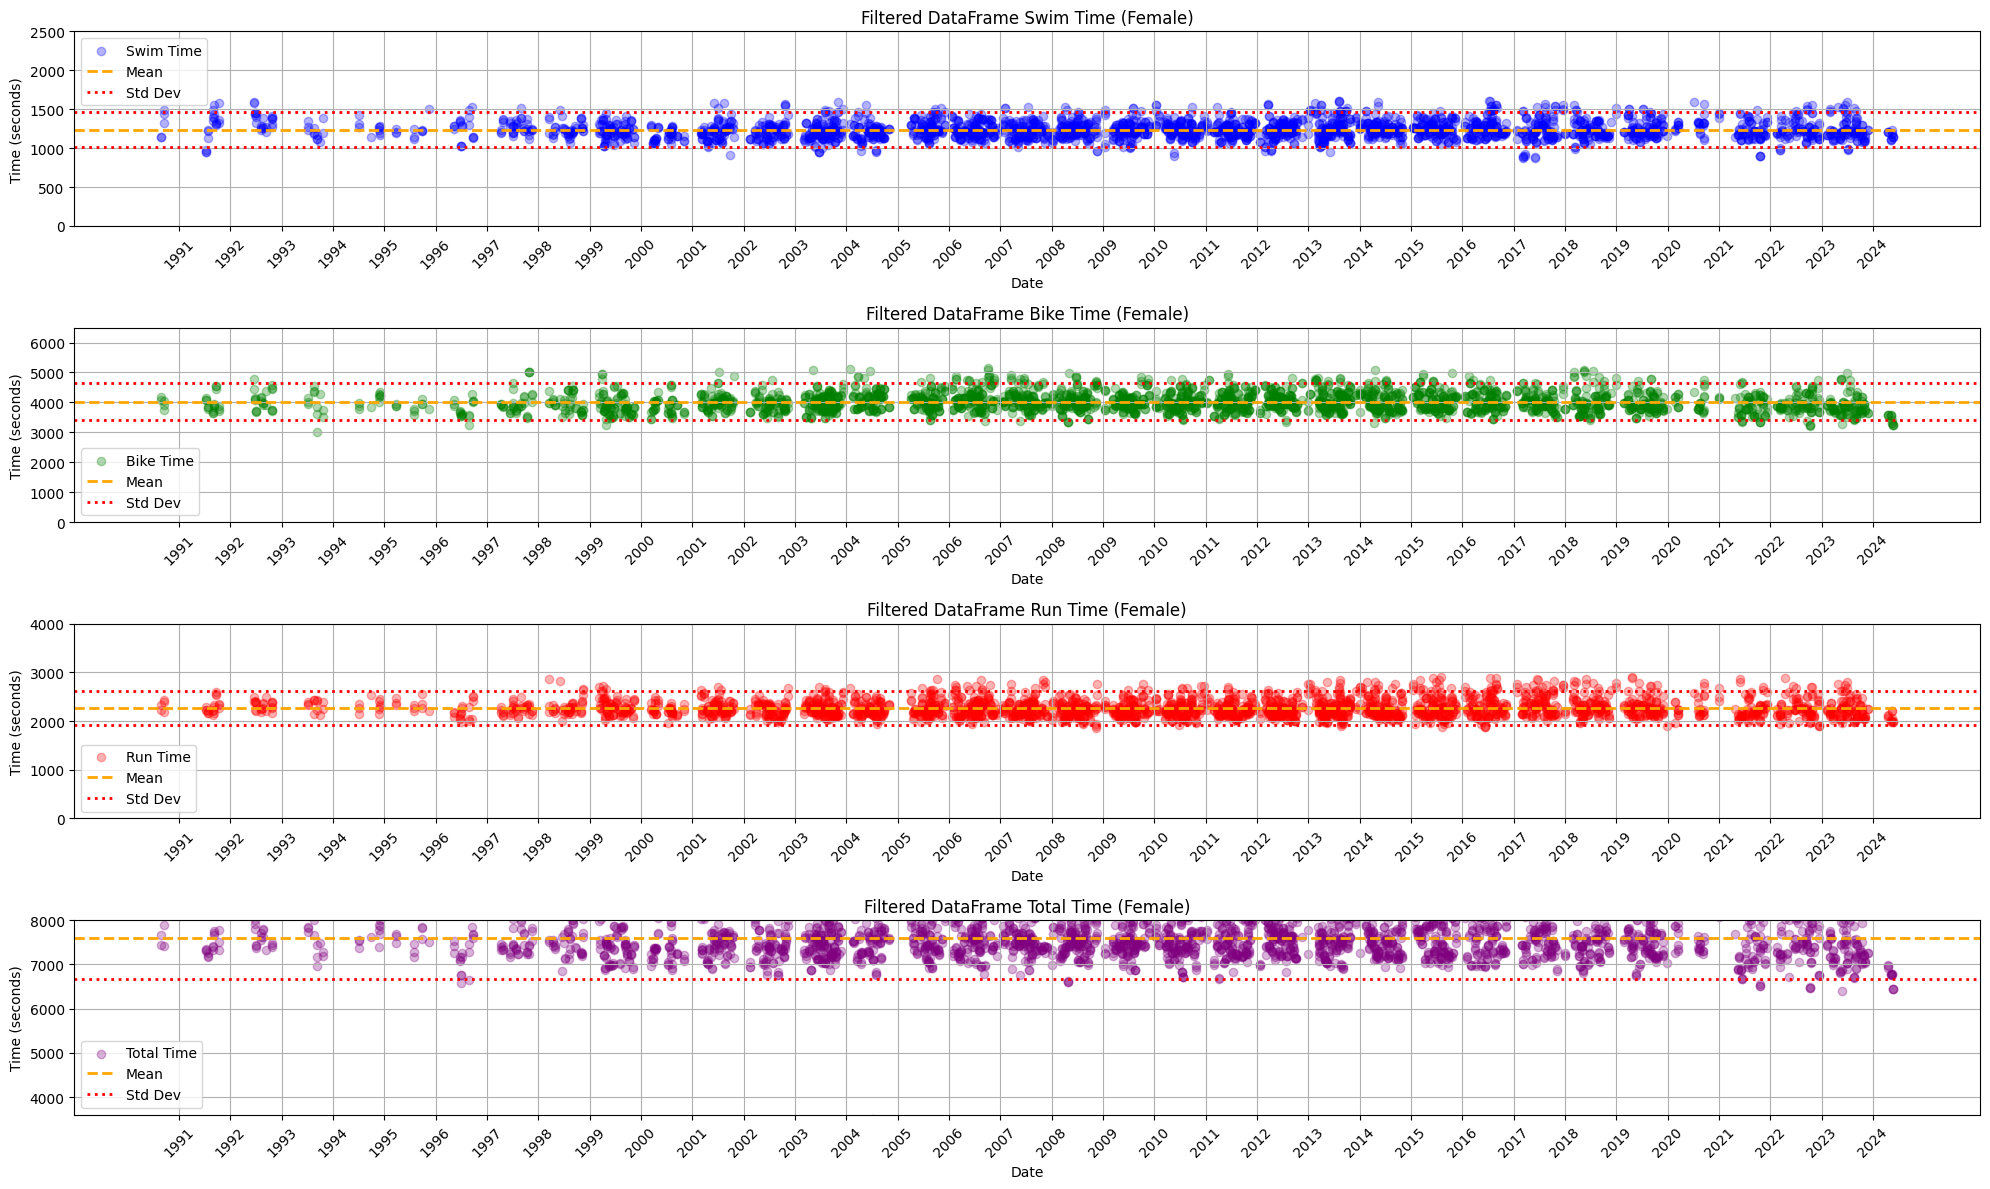

In [370]:
big_chart(filtered_df, "Filtered DataFrame")  # For filtered data

# Using regression approach to determine the future time
## Use all races to determining the future time.
- Linear regression: use the linear regression, like as a single olympic races, to determining the time of Paris 2024
- Polynomial regression: use polynomial regression (from 2 to 5) to determining the time of Paris 2024

In [371]:
# function to creare chart for regression and confidence interval from data filtered

filtered_df['date'] = pd.to_datetime(filtered_df['event_date'])
filtered_df['date_ordinal'] = filtered_df['date'].apply(lambda x: x.toordinal())

def plot_polynomial_regression(df, column, degree=1, color='blue', confidence_interval=0.95, extend_years=0):
    # data preparation
    end_date = df['date'].max() + timedelta(days=int(extend_years))
    years = pd.date_range(start=df['date'].min(),
                          end=end_date,
                          freq='YS')

    X = df['date_ordinal'].values.reshape(-1, 1)
    y = df[column].values

    # generate polynomila features for degrees
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # play polynomila regression
    model = LinearRegression()
    model.fit(X_poly, y)

    # prevision of the values in a range date
    X_range = np.linspace(X.min(), end_date.toordinal(), 300).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)
    y_pred = model.predict(X_range_poly)

    # Convert X_range from ordinal numebr to date
    dates_range = pd.to_datetime([pd.Timestamp.fromordinal(int(x)) for x in X_range.flatten()])

    # caluclatio of the confident interval
    from scipy import stats
    y_err = np.sqrt(np.sum((y - model.predict(X_poly))**2) / (len(y) - degree - 1))
    ci = stats.t.ppf((1 + confidence_interval) / 2., len(y) - degree - 1) * y_err

    # make chart
    plt.figure(figsize=(15, 4))
    sns.scatterplot(x=df['date'], y=df[column], color=color, label=f'Original Data ({column})', alpha=0.3)
    sns.lineplot(x=dates_range, y=y_pred, color='black', label=f'Regression (degree={degree})')
    plt.fill_between(dates_range, y_pred - ci, y_pred + ci, color='grey', alpha=0.3, label=f'Confidence Interval {confidence_interval}')

    plt.xlabel('Date')
    plt.ylabel(f'{column.capitalize()} (Seconds)')
    plt.title(f'{column.capitalize()} with Regression (degree={degree}) {sex}')
    plt.xticks(years.to_pydatetime(), years.year, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()




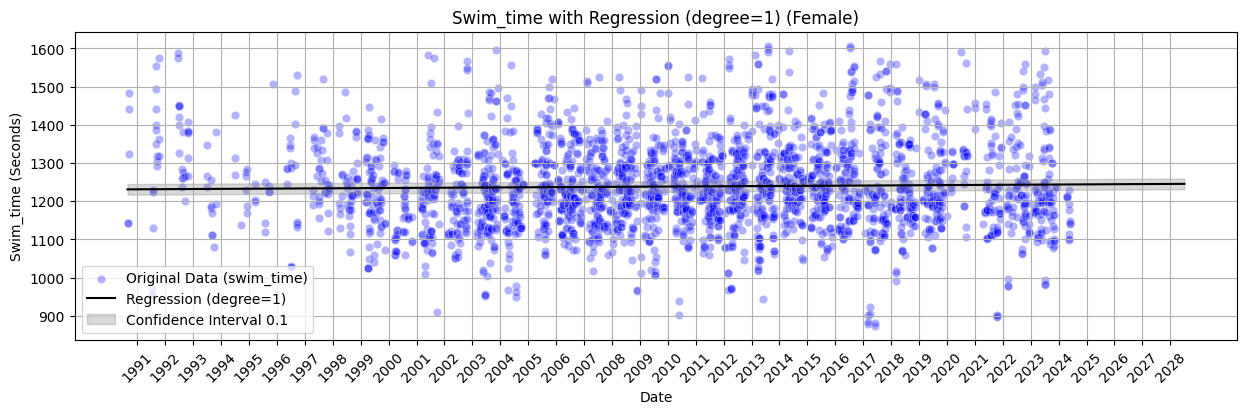

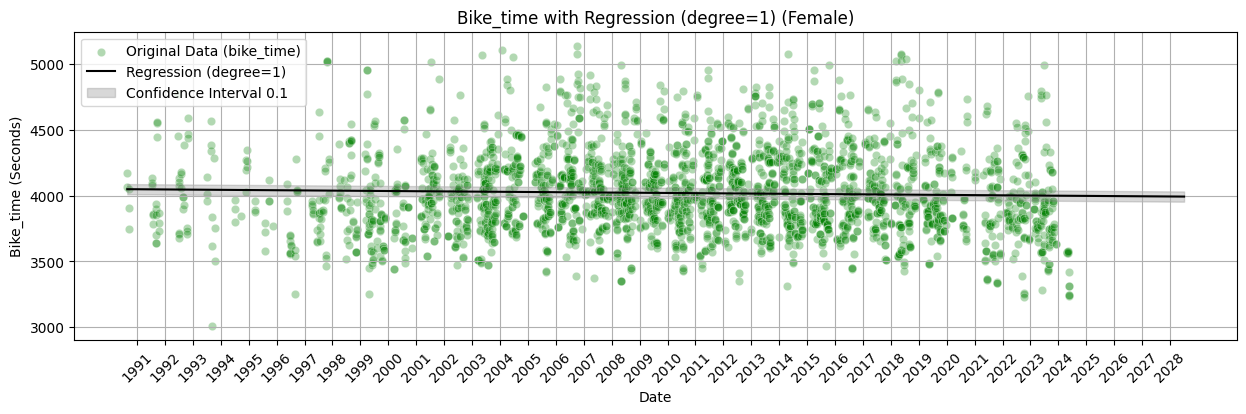

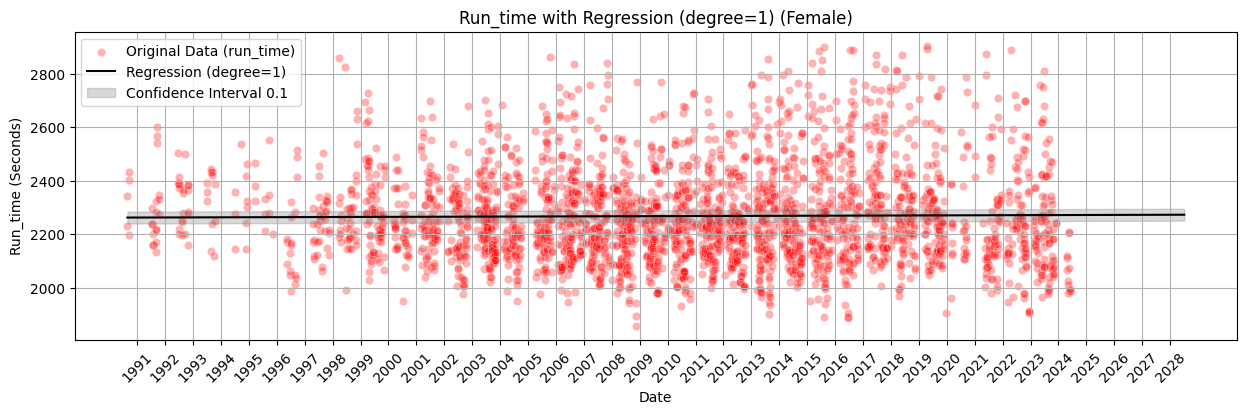

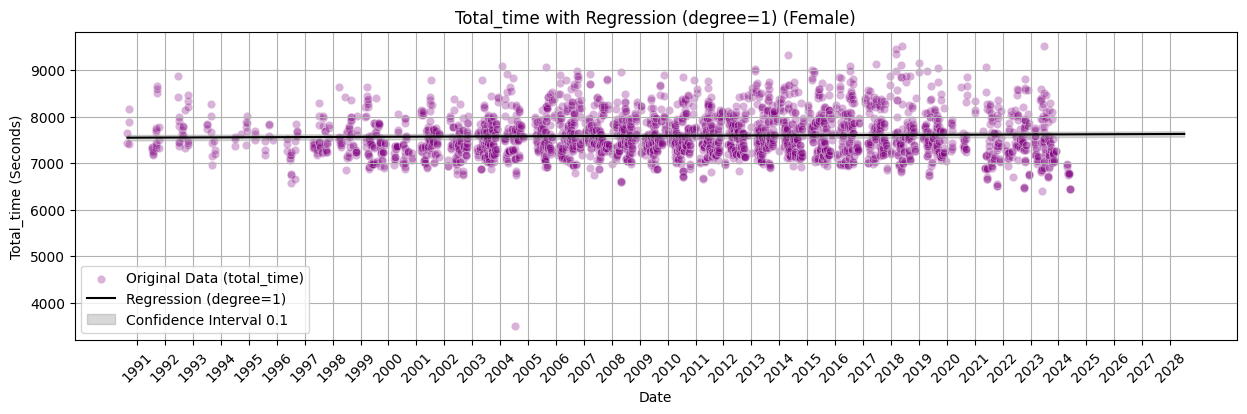

In [399]:
# make a chart for data and type of regression for original data
degree = 1 #set degre/s of the function
confidence_interval = 0.1 # set confident interval
extend_years = 1500 # set extended day

# make chart (set degree and confident interval)
plot_polynomial_regression(filtered_df, 'swim_time', degree=degree, color='blue', confidence_interval=confidence_interval, extend_years=extend_years)
plot_polynomial_regression(filtered_df, 'bike_time', degree=degree, color='green', confidence_interval=confidence_interval, extend_years=extend_years)
plot_polynomial_regression(filtered_df, 'run_time', degree=degree, color='red', confidence_interval=confidence_interval, extend_years=extend_years)
plot_polynomial_regression(filtered_df, 'total_time', degree=degree, color='purple', confidence_interval=confidence_interval, extend_years=extend_years)

In [373]:
# linear regression

filtered_df['date'] = pd.to_datetime(filtered_df['event_date'])

# Trasform data in ordinal number regression
filtered_df['date_ordinal'] = filtered_df['date'].apply(lambda x: x.toordinal())

#  linear regression for every column
regression_models = {}
for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
    X = filtered_df['date_ordinal'].values.reshape(-1, 1)
    y = filtered_df[col].values
    model = LinearRegression()
    model.fit(X, y)
    regression_models[col] = model
    print(f"{col.capitalize()} Regression {sex}: y = {model.coef_[0]:.4f}x + {model.intercept_:.4f} ")

# function to covert secondo in HH:MM:SS
def seconds_to_hms(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# make table with prevision HH:MM:SS
def create_prediction_table(start_date, num_days, models):
    # Inizializza le liste vuote per ogni colonna
    dates = []
    swim_time_seconds = []
    swim_time_hms = []
    bike_time_seconds = []
    bike_time_hms = []
    run_time_seconds = []
    run_time_hms = []
    total_time_seconds = []
    total_time_hms = []

    # make data
    for i in range(num_days):
        future_date = start_date + timedelta(days=i)
        dates.append(future_date)

        # prevision
        for col, seconds_list, hms_list in [
            ('swim_time', swim_time_seconds, swim_time_hms),
            ('bike_time', bike_time_seconds, bike_time_hms),
            ('run_time', run_time_seconds, run_time_hms),
            ('total_time', total_time_seconds, total_time_hms)
        ]:
            future_ordinal = future_date.toordinal()
            future_ordinal_array = np.array([[future_ordinal]])
            future_pred = models[col].predict(future_ordinal_array)[0]

            # add second and HH:MM:SS
            seconds_list.append(future_pred)
            hms_list.append(seconds_to_hms(future_pred))

    # final DataFrame
    prediction_df = pd.DataFrame({
        'Date': dates,
        'Swim_Time_Seconds': swim_time_seconds,
        'Swim_Time_HMS': swim_time_hms,
        'Bike_Time_Seconds': bike_time_seconds,
        'Bike_Time_HMS': bike_time_hms,
        'Run_Time_Seconds': run_time_seconds,
        'Run_Time_HMS': run_time_hms,
        'Total_Time_Seconds': total_time_seconds,
        'Total_Time_HMS': total_time_hms
    })

    return prediction_df






# set range for prevision
start_date = pd.to_datetime('2024-05-26')
num_days = 67  # set day befor date

# make table for prevision
prediction_table = create_prediction_table(start_date, num_days, regression_models)

# visualize table
prediction_table.tail()


Swim_time Regression (Female): y = 0.0010x + 473.7391 
Bike_time Regression (Female): y = -0.0041x + 6999.2827 
Run_time Regression (Female): y = 0.0008x + 1702.8221 
Total_time Regression (Female): y = 0.0058x + 3344.9640 


Date  Swim_Time_Seconds Swim_Time_HMS  Bike_Time_Seconds  \
62 2024-07-27        1243.886439      00:20:43        3998.872498   
63 2024-07-28        1243.887481      00:20:43        3998.868439   
64 2024-07-29        1243.888523      00:20:43        3998.864379   
65 2024-07-30        1243.889566      00:20:43        3998.860320   
66 2024-07-31        1243.890608      00:20:43        3998.856260   

   Bike_Time_HMS  Run_Time_Seconds Run_Time_HMS  Total_Time_Seconds  \
62      01:06:38       2271.560306     00:37:51         7619.291739   
63      01:06:38       2271.561075     00:37:51         7619.297522   
64      01:06:38       2271.561845     00:37:51         7619.303306   
65      01:06:38       2271.562614     00:37:51         7619.309089   
66      01:06:38       2271.563384     00:37:51         7619.314872   

   Total_Time_HMS  
62       02:06:59  
63       02:06:59  
64       02:06:59  
65       02:06:59  
66       02:06:59

In [374]:
def calculate_r_squared(filtered_df, x_column='event_date', y_column='swim_time', degree=1):

    # Trasforma le date in numeri ordinali
    filtered_df['date_ordinal'] = filtered_df[x_column].apply(lambda x: x.toordinal())
    X = filtered_df['date_ordinal'].values.reshape(-1, 1)
    y = filtered_df[y_column].values

    # Genera feature polinomiali in base al grado specificato
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Esegui la regressione polinomiale
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predici i valori y usando il modello
    y_pred = model.predict(X_poly)

    # Calcola il coefficiente di determinazione R^2
    ss_total = np.sum((y - np.mean(y))**2)  # Somma dei quadrati totali
    ss_residual = np.sum((y - y_pred)**2)  # Somma dei quadrati residui
    r_squared = 1 - (ss_residual / ss_total)

    return r_squared

# utilizzo della funzione
filtered_df['event_date'] = pd.to_datetime(filtered_df['event_date'])

# Calcola R^2 per la regressione lineare (grado 1) per swim_time
r_squared_swim = calculate_r_squared(filtered_df, x_column='event_date', y_column='swim_time', degree=1)
r_squared_bike = calculate_r_squared(filtered_df, x_column='event_date', y_column='bike_time', degree=1)
r_squared_run = calculate_r_squared(filtered_df, x_column='event_date', y_column='run_time', degree=1)
r_squared_total = calculate_r_squared(filtered_df, x_column='event_date', y_column='total_time', degree=1)
print(f"R^2 for linear regression of swim_time {sex}: {r_squared_swim:.4f}")
print(f"R^2 for linear regression of bike_time {sex}: {r_squared_bike:.4f}")
print(f"R^2 for linear regression of run_time {sex}: {r_squared_run:.4f}")
print(f"R^2 for linear regression of total_time {sex}: {r_squared_total:.4f}")

# Calcola R^2 per la regressione polinomiale di grado 2 per bike_time

degree = 3 # set the degree
r_squared_swim = calculate_r_squared(filtered_df, x_column='event_date', y_column='swim_time', degree=degree)
r_squared_bike = calculate_r_squared(filtered_df, x_column='event_date', y_column='bike_time', degree=degree)
r_squared_run = calculate_r_squared(filtered_df, x_column='event_date', y_column='run_time', degree=degree)
r_squared_total = calculate_r_squared(filtered_df, x_column='event_date', y_column='total_time', degree=degree)
print(f"R^2 for polynomila regression of swim_time (grado {degree}) {sex}: {r_squared_swim:.4f}")
print(f"R^2 for polynomila regression of bike_time (grado {degree}) {sex}: {r_squared_bike:.4f}")
print(f"R^2 for polynomila regression of run_time (grado {degree}) {sex}: {r_squared_run:.4f}")
print(f"R^2 for polynomila regression of total_time (grado {degree}) {sex}: {r_squared_total:.4f}")

R^2 for linear regression of swim_time (Female): 0.0006
R^2 for linear regression of bike_time (Female): 0.0013
R^2 for linear regression of run_time (Female): 0.0001
R^2 for linear regression of total_time (Female): 0.0011
R^2 for polynomila regression of swim_time (grado 3) (Female): 0.0019
R^2 for polynomila regression of bike_time (grado 3) (Female): 0.0252
R^2 for polynomila regression of run_time (grado 3) (Female): 0.0008
R^2 for polynomila regression of total_time (grado 3) (Female): 0.0073


In [375]:
# polynomial regression

filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Trasform data in ordinal number for regression
filtered_df['date_ordinal'] = filtered_df['date'].apply(lambda x: x.toordinal())

# define pynomila degrees
polynomial_degree = 3 # change data fro degrees

# polynomial regression for every columno
polynomial_features = PolynomialFeatures(degree=polynomial_degree)
regression_models = {}

for col in ['swim_time', 'bike_time', 'run_time', 'total_time']:
    X_poly = polynomial_features.fit_transform(filtered_df['date_ordinal'].values.reshape(-1, 1))
    y = filtered_df[col].values
    model = LinearRegression()
    model.fit(X_poly, y)
    regression_models[col] = model
    print(f"{col.capitalize()} Polynomial Regression (degree={polynomial_degree}): Coefficients={model.coef_}, Intercept={model.intercept_}")

# function to convert second in HH:MM:SS
def seconds_to_hms(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# make table in second and HH:MM:SS
def create_prediction_table_poly(start_date, num_days, models, poly_features):
    # empty list
    dates = []
    swim_time_seconds = []
    swim_time_hms = []
    bike_time_seconds = []
    bike_time_hms = []
    run_time_seconds = []
    run_time_hms = []
    total_time_seconds = []
    total_time_hms = []

    # create list
    for i in range(num_days):
        future_date = start_date + timedelta(days=i)
        dates.append(future_date)

        # prevision for every column
        for col, seconds_list, hms_list in [
            ('swim_time', swim_time_seconds, swim_time_hms),
            ('bike_time', bike_time_seconds, bike_time_hms),
            ('run_time', run_time_seconds, run_time_hms),
            ('total_time', total_time_seconds, total_time_hms)
        ]:
            future_ordinal = np.array([[future_date.toordinal()]])
            future_ordinal_poly = poly_features.transform(future_ordinal)
            future_pred = models[col].predict(future_ordinal_poly)[0]

            # add values in second and HH:MM:SS
            seconds_list.append(future_pred)
            hms_list.append(seconds_to_hms(future_pred))

    # final DataFrame
    prediction_df = pd.DataFrame({
        'Date': dates,
        'Swim_Time_Seconds': swim_time_seconds,
        'Swim_Time_HMS': swim_time_hms,
        'Bike_Time_Seconds': bike_time_seconds,
        'Bike_Time_HMS': bike_time_hms,
        'Run_Time_Seconds': run_time_seconds,
        'Run_Time_HMS': run_time_hms,
        'Total_Time_Seconds': total_time_seconds,
        'Total_Time_HMS': total_time_hms
    })

    return prediction_df

# set the day for prevision
start_date = pd.to_datetime('2024-05-26') # start date
num_days = 67  # write the number of days after the date

# make table
prediction_table_poly = create_prediction_table_poly(start_date, num_days, regression_models, polynomial_features)

# table visualization
prediction_table_poly.head()

Swim_time Polynomial Regression (degree=3): Coefficients=[ 0.00000000e+00 -6.14532282e-13 -4.50705334e-07  4.10169487e-13], Intercept=81855.24699729746
Bike_time Polynomial Regression (degree=3): Coefficients=[ 0.00000000e+00  7.49942966e-12  5.50017151e-06 -5.00013269e-12], Intercept=-981903.9102038696
Run_time Polynomial Regression (degree=3): Coefficients=[ 0.00000000e+00 -7.14123705e-13 -5.23746876e-07  4.76368460e-13], Intercept=96057.17187017718
Total_time Polynomial Regression (degree=3): Coefficients=[ 0.00000000e+00  5.66606087e-12  4.15555689e-06 -3.77228112e-12], Intercept=-739474.3878379444


Date  Swim_Time_Seconds Swim_Time_HMS  Bike_Time_Seconds  \
0 2024-05-26        1253.391324      00:20:53        3882.595111   
1 2024-05-27        1253.397218      00:20:53        3882.531969   
2 2024-05-28        1253.403112      00:20:53        3882.468816   
3 2024-05-29        1253.409008      00:20:53        3882.405652   
4 2024-05-30        1253.414905      00:20:53        3882.342477   

  Bike_Time_HMS  Run_Time_Seconds Run_Time_HMS  Total_Time_Seconds  \
0      01:04:42       2282.620190     00:38:02         7531.147271   
1      01:04:42       2282.626591     00:38:02         7531.108544   
2      01:04:42       2282.632993     00:38:02         7531.069810   
3      01:04:42       2282.639397     00:38:02         7531.031067   
4      01:04:42       2282.645801     00:38:02         7530.992315   

  Total_Time_HMS  
0       02:05:31  
1       02:05:31  
2       02:05:31  
3       02:05:31  
4       02:05:30

In [376]:
def reg_chart(df, degree):
    plt.figure(figsize=(10, 18))

    month = pd.date_range(start=df['Date'].min(),
                          end=df['Date'].max(),
                          freq='M')

    plt.subplot(4, 1, 1)
    plt.plot(df['Date'], df['Swim_Time_Seconds'], marker='.', alpha=0.3, color="blue")
    plt.xlabel('Date')
    plt.ylabel('Swim Time (Seconds)')
    plt.title(f'Swim Time prediction {degree} {sex}')
    plt.xticks(month.to_pydatetime(), rotation=90)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(df['Date'], df['Bike_Time_Seconds'], marker='.', alpha=0.3, color="green")
    plt.xlabel('Date')
    plt.ylabel('Bike Time (Seconds)')
    plt.title(f'Bike Time prediction {degree} {sex}')
    plt.xticks(month.to_pydatetime(), rotation=90)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.plot(df['Date'], df['Run_Time_Seconds'], marker='.', alpha=0.3, color="red")
    plt.xlabel('Date')
    plt.ylabel('Run Time (Seconds)')
    plt.title(f'Run Time prediction {degree} {sex}')
    plt.xticks(month.to_pydatetime(), rotation=90)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.plot(df['Date'], df['Total_Time_Seconds'], marker='.', alpha=0.3, color="purple")
    plt.xlabel('Date')
    plt.ylabel('Total Time (Seconds)')
    plt.title(f'Total Time prediction {degree} {sex}')
    plt.xticks(month.to_pydatetime(), rotation=90)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)

    plt.tight_layout(pad=1.0)
    plt.show()


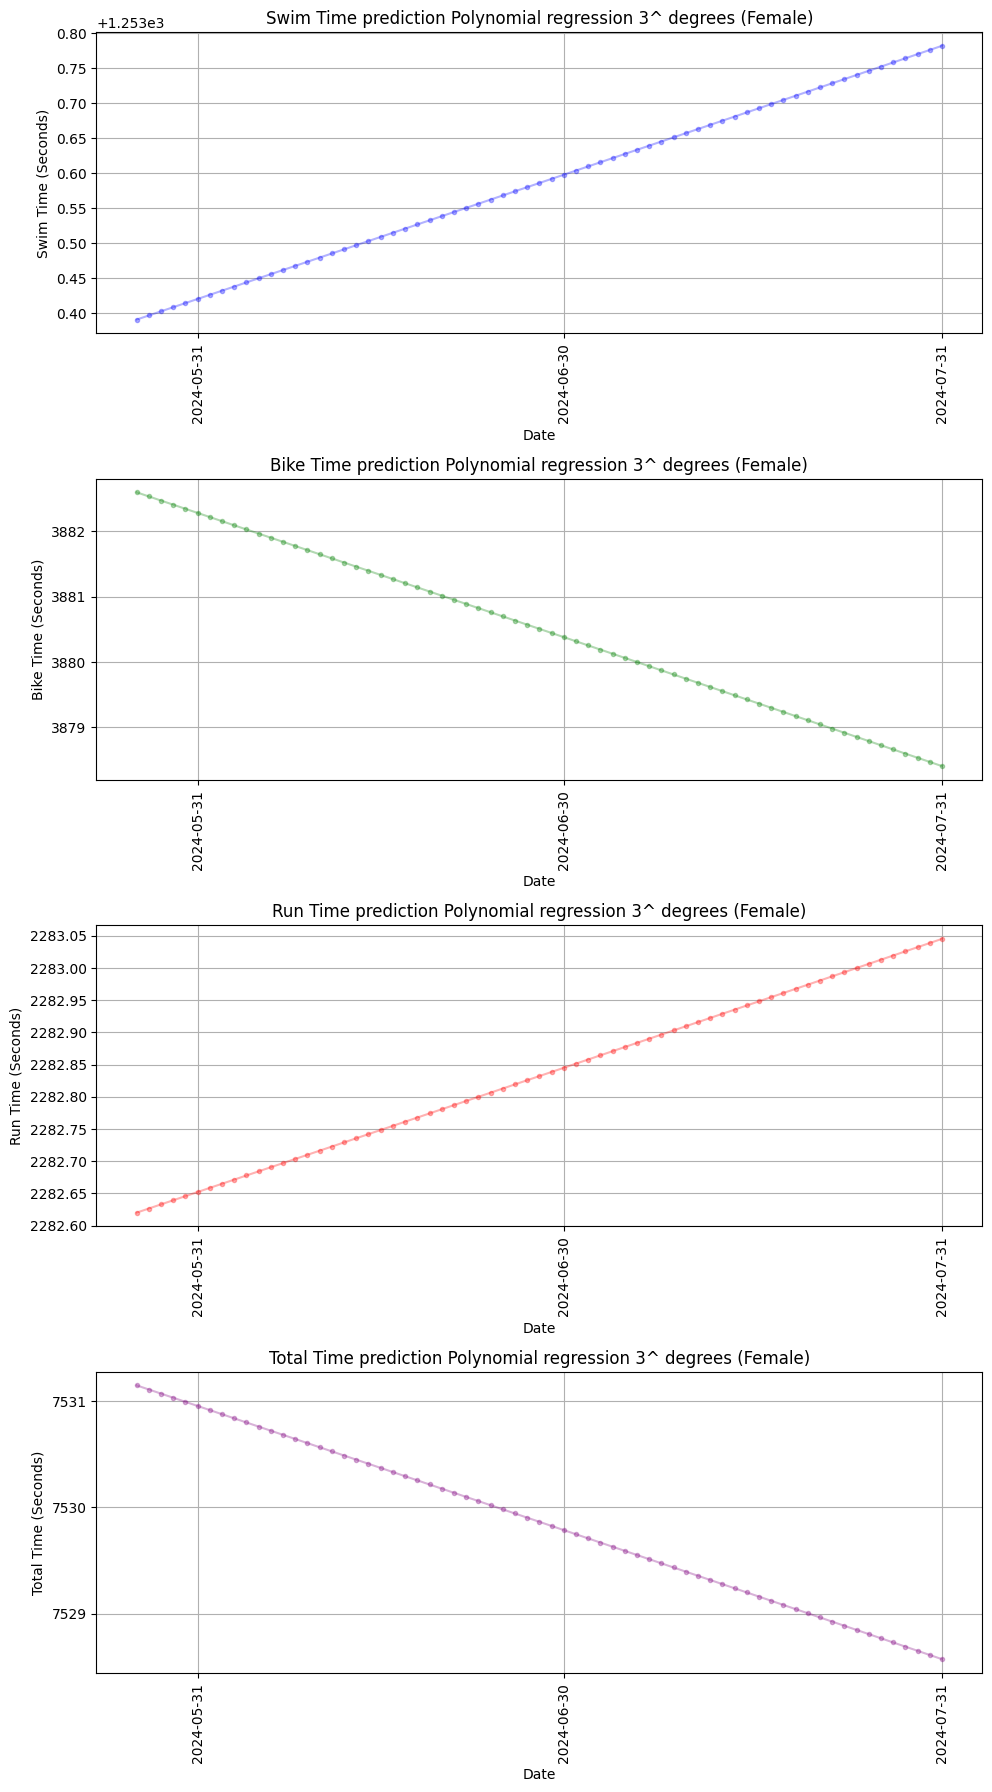

In [377]:
reg_chart(prediction_table_poly, "Polynomial regression 3^ degrees")

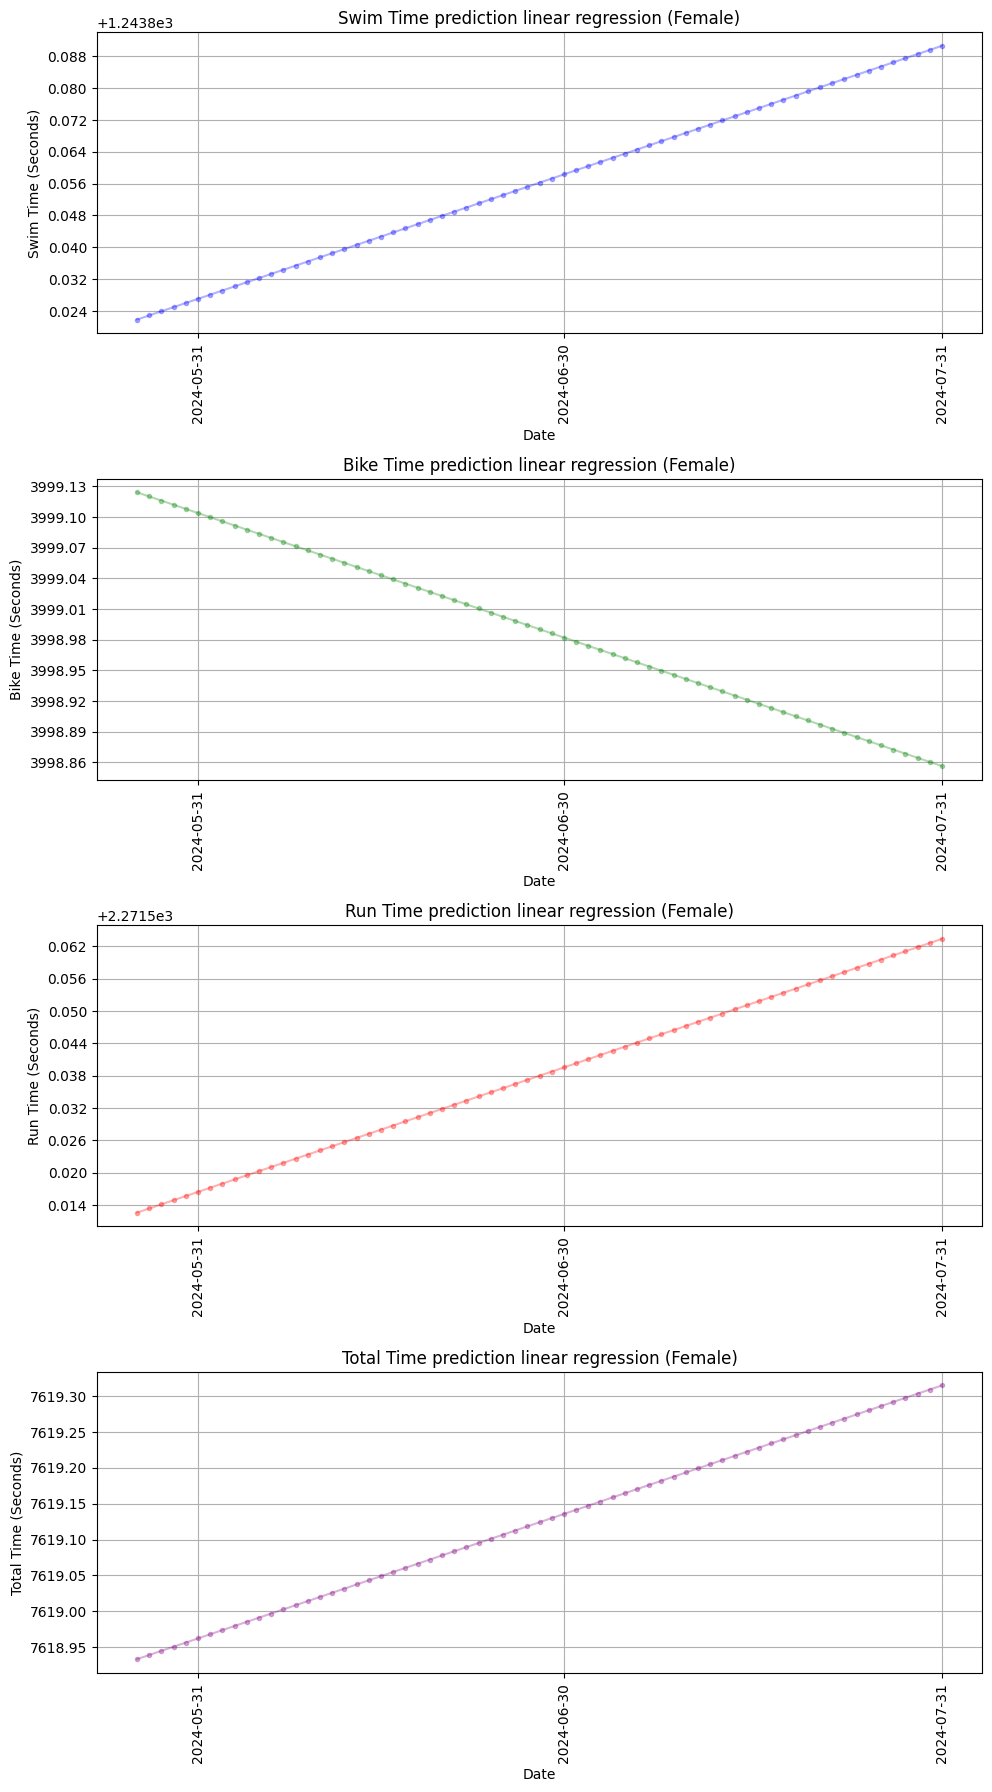

In [378]:
reg_chart(prediction_table, "linear regression")

# Using Tensorflow

Tensorflow is a machine learning base approach from Google

In [379]:
# Select features and target
features = [col for col in filtered_df.columns if 'lag' in col]
target = ['swim_time', 'bike_time', 'run_time', 'total_time']

In [461]:
# split data in test and training set
X = filtered_df[features]
y = filtered_df[target]

# change the number if you want to modify the % of division
# male 0.2, female 0.2

validation_split = 0.01
split_index = int(X.shape[0] * (1 - validation_split))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)



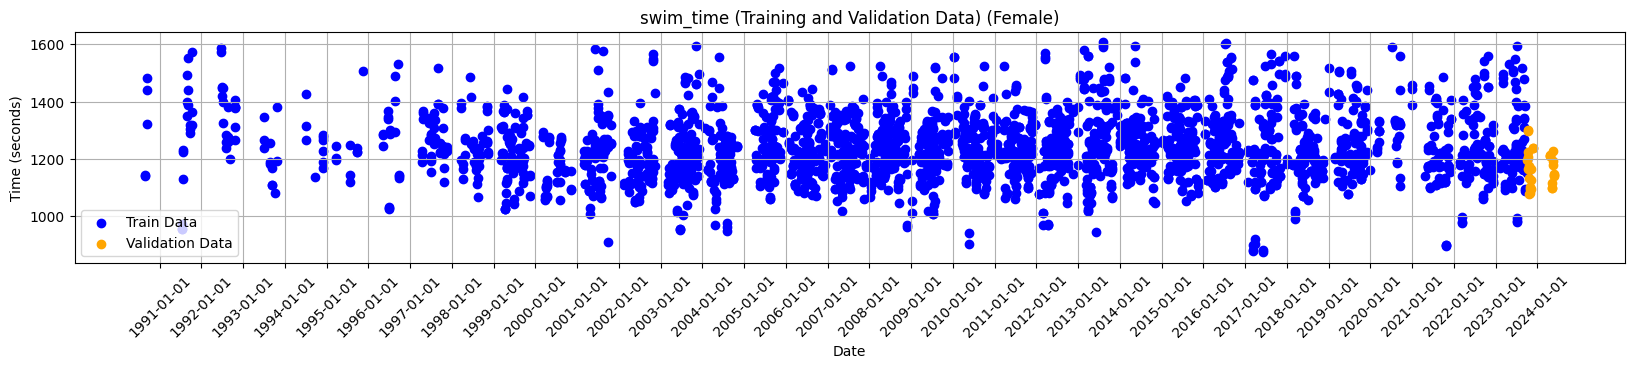

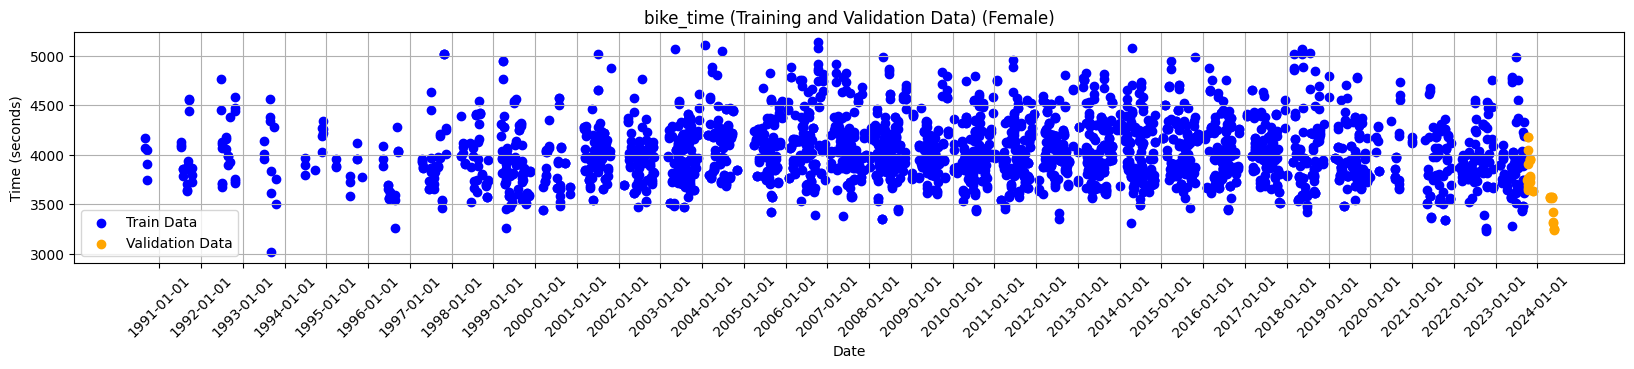

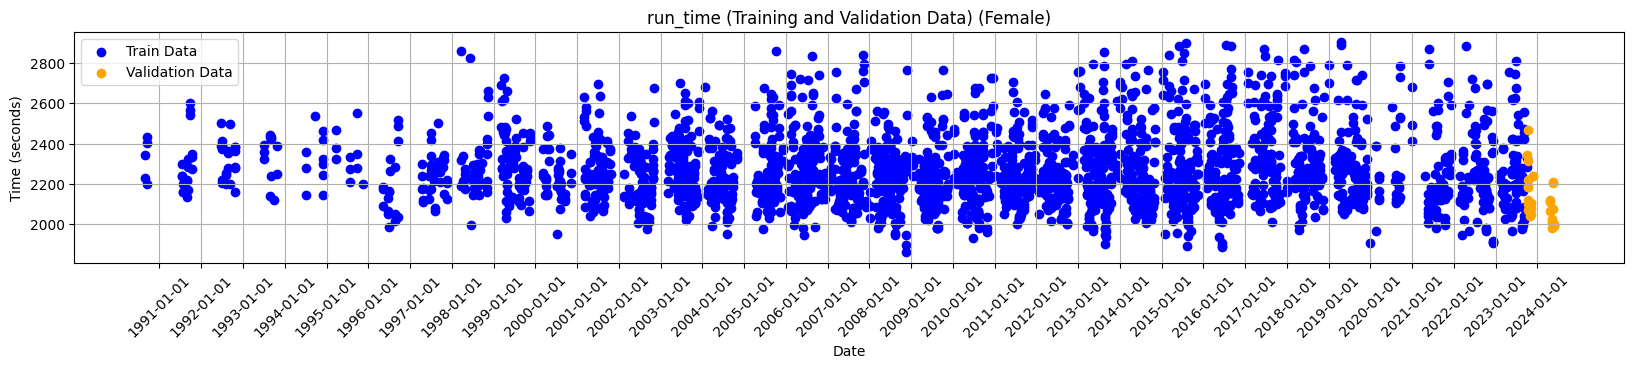

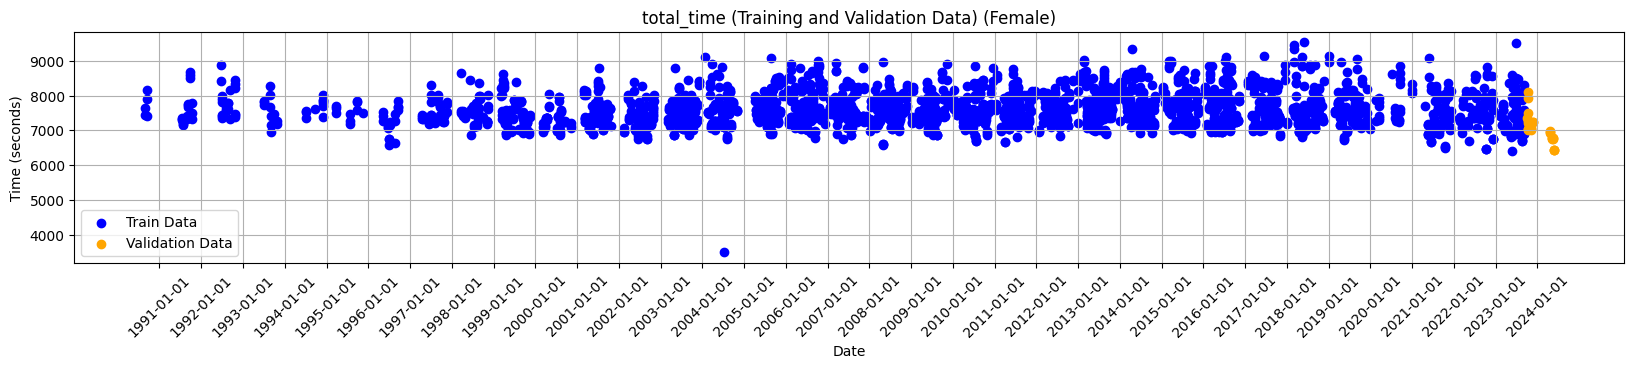

In [462]:
# Plot function for train and validation data
def plot_train_val(train_df, val_df, feature):
    plt.figure(figsize=(20, 3))

    # Plot train data
    plt.scatter(train_df['event_date'], train_df[feature], label='Train Data', color='blue')

    # Plot validation data
    plt.scatter(val_df['event_date'], val_df[feature], label='Validation Data', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Time (seconds)')
    plt.title(f'{feature} (Training and Validation Data) {sex}')
    plt.legend()
    plt.grid(True)
    plt.xticks(pd.date_range(start=min(train_df['event_date'].min(), val_df['event_date'].min()),
                             end=max(train_df['event_date'].max(), val_df['event_date'].max()),
                             freq='YS').to_pydatetime(),
               rotation=45)
    plt.show()

# Create validation DataFrame for plotting purposes
val_df_avg = filtered_df[split_index:].copy()

# Plot for 'swim_time'
plot_train_val(filtered_df[:split_index], val_df_avg, 'swim_time')

# Plot for 'bike_time'
plot_train_val(filtered_df[:split_index], val_df_avg, 'bike_time')

# Plot for 'run_time'
plot_train_val(filtered_df[:split_index], val_df_avg, 'run_time')

# Plot for 'total_time'
plot_train_val(filtered_df[:split_index], val_df_avg, 'total_time')


In [463]:
def build_model(input_shape):
    model = Sequential([
        #Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)), Dropout(0.001),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.03),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.03),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.03),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.03),
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.03),
        Dense(4)  # Assuming 4 target outputs: swim_time, bike_time, run_time, total_time
    ], name = "tensorflow_pred")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [464]:
# Assuming 'history' is the history object returned by model.fit
def plot_learning_curves(history):
    epochs = len(history.history['loss'])  # calculation for epochs number

    # modify the legend label to include the epochs number
    plt.plot(history.history['loss'], label=f'Train (Epochs: {epochs})')
    plt.plot(history.history['val_loss'], label=f'Validation (Epochs: {epochs})')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curves')
    plt.show()


In [465]:
# Set epochs (add any number)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # patience orginal = 10

epochs_list = [300]
results = []

for epochs in epochs_list:
    print(f"Training with epochs={epochs}")
    model = build_model(X_train_scaled.shape[1]) #
    #history = model.fit(X_train_scaled, y_train_scaled, epochs=76, validation_data=(X_val_scaled, y_val_scaled), verbose=0)
    history = model.fit(X_train_scaled, y_train_scaled,
                        epochs=300,
                        validation_data=(X_val_scaled, y_val_scaled),
                        callbacks=[early_stopping],
                        verbose=0)

    # Predict on validation data
    y_pred_scaled = model.predict(X_val_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_val_inverse = scaler_y.inverse_transform(y_val_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_val_inverse, y_pred, multioutput='raw_values')
    mse = mean_squared_error(y_val_inverse, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_inverse, y_pred, multioutput='raw_values')
    mape = mean_absolute_percentage_error(y_val_inverse, y_pred)

    # Perform cross-validation manually
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae_scores = []
    for train_index, test_index in kf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Scale the data
        X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
        X_test_cv_scaled = scaler_X.transform(X_test_cv)
        y_train_cv_scaled = scaler_y.fit_transform(y_train_cv)
        y_test_cv_scaled = scaler_y.transform(y_test_cv)

        # Build and train the model
        model_cv = build_model(X_train_cv_scaled.shape[1])
        model_cv.fit(X_train_cv_scaled, y_train_cv_scaled, epochs=epochs, verbose=0)

        # Predict and evaluate
        y_pred_cv_scaled = model_cv.predict(X_test_cv_scaled)
        y_pred_cv = scaler_y.inverse_transform(y_pred_cv_scaled)
        y_test_cv_inverse = scaler_y.inverse_transform(y_test_cv_scaled)

        mae_cv = mean_absolute_error(y_test_cv_inverse, y_pred_cv, multioutput='raw_values')
        cv_mae_scores.append(mae_cv.mean())  # Average MAE for the current fold

    cross_val_mae = np.mean(cv_mae_scores)

    results.append({
        'epochs': len(history.history['loss']),
        'mae_swim': mae[0],
        'mae_bike': mae[1],
        'mae_run': mae[2],
        'mae_total': mae[3],
        'mse_swim': mse[0],
        'mse_bike': mse[1],
        'mse_run': mse[2],
        'mse_total': mse[3],
        'rmse_swim': rmse[0],
        'rmse_bike': rmse[1],
        'rmse_run': rmse[2],
        'rmse_total': rmse[3],
        'r2_swim': r2[0],
        'r2_bike': r2[1],
        'r2_run': r2[2],
        'r2_total': r2[3],
        'mape': mape,
        'cross_val_mae': cross_val_mae
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
df1_transposed = results_df.T
df1_transposed

Training with epochs=300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0
epochs             57.000000
mae_swim           54.175255
mae_bike          240.031258
mae_run           105.327460
mae_total         360.953815
mse_swim         4362.287499
mse_bike        92626.213795
mse_run         15768.887520
mse_total      196978.137590
rmse_swim          66.047615
rmse_bike         304.345550
rmse_run          125.574231
rmse_total        443.822191
r2_swim            -0.172039
r2_bike            -0.394694
r2_run             -0.180608
r2_total           -0.431155
mape                0.055025
cross_val_mae     169.914995

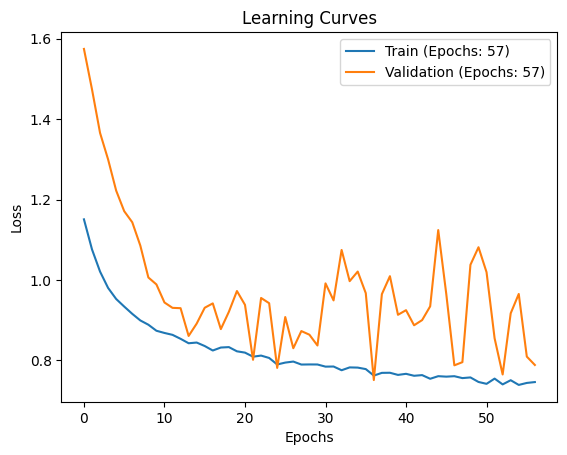

In [466]:
plot_learning_curves(history)


Create a chart to visualize MAE and RMSE

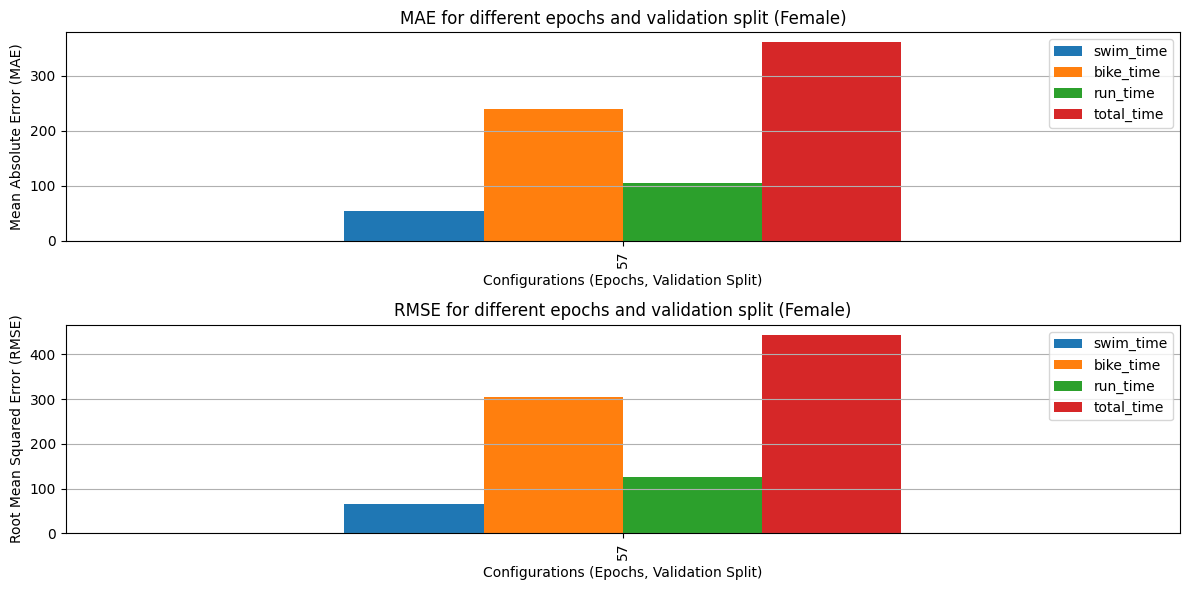

In [467]:
# Result chart creation
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# MAE istogram
results_df.plot(kind='bar', x='epochs', y=['mae_swim', 'mae_bike', 'mae_run', 'mae_total'], ax=ax[0])
ax[0].set_title(f'MAE for different epochs and validation split {sex}')
ax[0].set_xlabel('Configurations (Epochs, Validation Split)')
ax[0].set_ylabel('Mean Absolute Error (MAE)')
ax[0].legend(['swim_time', 'bike_time', 'run_time', 'total_time'])
ax[0].grid(axis="y")

# RMSE istogram
results_df.plot(kind='bar', x='epochs', y=['rmse_swim', 'rmse_bike', 'rmse_run', 'rmse_total'], ax=ax[1])
ax[1].set_title(f'RMSE for different epochs and validation split {sex}')
ax[1].set_xlabel('Configurations (Epochs, Validation Split)')
ax[1].set_ylabel('Root Mean Squared Error (RMSE)')
ax[1].legend(['swim_time', 'bike_time', 'run_time', 'total_time'])
ax[1].grid(axis="y")

plt.tight_layout()
plt.show()

In [468]:
def prediction_tf(results_df):
    # make a list to store the formatted data
    formatted_results = []

    for index, row in results_df.iterrows():
        # sum of the swim, bike and run time
        total_sum = row['Predicted_swim_time'] + row['Predicted_bike_time'] + row['Predicted_run_time']

        # conversion of the time in HH:MM:SS
        predicted_swim_time = second_to_time(row['Predicted_swim_time'])
        predicted_bike_time = second_to_time(row['Predicted_bike_time'])
        predicted_run_time = second_to_time(row['Predicted_run_time'])
        predicted_total_time = second_to_time(row['Predicted_total_time'])
        sum_total_time = second_to_time(total_sum)

        # add data in a dict
        formatted_results.append({
            'Day': row['Day'],
            'Swim_Time': f"{predicted_swim_time[0]:02d}:{predicted_swim_time[1]:02d}:{predicted_swim_time[2]:02d}",
            'Bike_Time': f"{predicted_bike_time[0]:02d}:{predicted_bike_time[1]:02d}:{predicted_bike_time[2]:02d}",
            'Run_Time': f"{predicted_run_time[0]:02d}:{predicted_run_time[1]:02d}:{predicted_run_time[2]:02d}",
            'Total_Time': f"{predicted_total_time[0]:02d}:{predicted_total_time[1]:02d}:{predicted_total_time[2]:02d}",
            'Sum_of_Swim_Bike_Run': f"{sum_total_time[0]:02d}:{sum_total_time[1]:02d}:{sum_total_time[2]:02d}",
        #     'Predicted_swim_time': f"{future_pred_tf[0][0]:.2f}",
        #     'Predicted_bike_time': f"{future_pred_tf[0][1]:.2f}",
        #     'Predicted_run_time': f"{future_pred_tf[0][2]:.2f}",
        #     'Predicted_total_time': f"{future_pred_tf[0][3]:.2f}"
         })

    # make a dataframe
    formatted_df = pd.DataFrame(formatted_results)
    return formatted_df

# function for data formatting (second to HH:MM:SS)

def second_to_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

In [469]:
# Set the range of prediction days
start_day = 3
end_day = 4

# Base features copied from the last row of X_train
base_features = X_train.iloc[-1:].copy()

# Column index map
col_index_map = {
    'swim_time': 0,
    'bike_time': 1,
    'run_time': 2,
    'total_time': 3
}

# Empty list for storing predicted values
predicted_values = []

# Empty list to store the results
results = []

# Loop for each day in the range start_day to end_day
for future_day in range(start_day, end_day + 1):
    future_features = base_features.copy()

    for col in future_features.columns:
        lag = int(col.split('_')[-1])
        if lag == 1:
            # Use the prediction of the previous day for lag_1
            if len(predicted_values) > 0:
                original_col = col.replace(f'_lag_{lag}', '')
                future_features[col] = predicted_values[-1][0][col_index_map[original_col]]
            else:
                future_features[col] = filtered_df.iloc[-1][col.replace(f'_lag_{lag}', '')]
        elif lag > 1:
            # Use the previous day's lag feature for lag > 1
            previous_day_col = col.replace(f'_lag_{lag}', f'_lag_{lag-1}')
            if previous_day_col in future_features.columns:
                future_features[col] = future_features[previous_day_col]
            else:
                future_features[col] = np.nan

    # Ensure all required columns are present by filling with NaN where necessary
    for col in X_train.columns:
        if col not in future_features.columns:
            future_features[col] = np.nan

    future_features = future_features[X_train.columns]  # Reorder columns to match the training data

    # Check if future_features is empty or contains NaN
    if future_features.isnull().all().all():
        print(f"Error: there's no data in this day {future_day}.")
    else:
        future_features_scaled = scaler_X.transform(future_features)
        future_pred_scaled = model.predict(future_features_scaled)
        future_pred_tf = scaler_y.inverse_transform(future_pred_scaled)

        print(f"Day {future_day} predictions:", future_pred_tf)


        # Add data to the results list
        results.append({
            'Day': future_day,
            'Predicted_swim_time': future_pred_tf[0][0],
            'Predicted_bike_time': future_pred_tf[0][1],
            'Predicted_run_time': future_pred_tf[0][2],
            'Predicted_total_time': future_pred_tf[0][3]
        })

        # Update predicted values with the new predictions
        predicted_values.append(future_pred_tf)

        # Update base_features with the latest predictions
        base_features = future_features.copy()

# Create a DataFrame to visualize the data
results_df = pd.DataFrame(results)

formatted_df = prediction_tf(results_df)
formatted_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Day 3 predictions: [[1220.7659 3895.9734 2230.04   7419.3965]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Day 4 predictions: [[1220.017  3947.9849 2236.2483 7463.2427]]


Day Swim_Time Bike_Time  Run_Time Total_Time Sum_of_Swim_Bike_Run
0  3.0  00:20:20  01:04:55  00:37:10   02:03:39             02:02:26
1  4.0  00:20:20  01:05:47  00:37:16   02:04:23             02:03:24

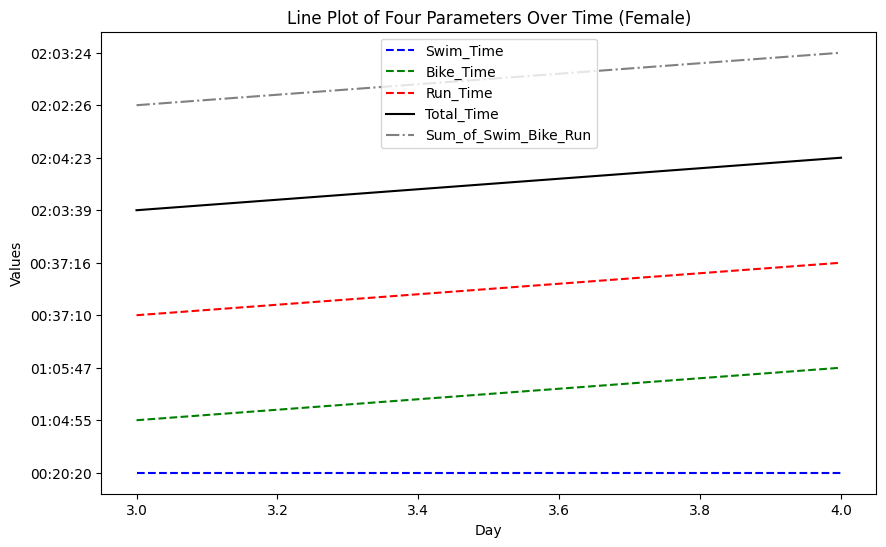

In [470]:
plt.figure(figsize=(10, 6))

# set the line for parameters
plt.plot(formatted_df['Day'], formatted_df['Swim_Time'], ls="--", color="blue", label='Swim_Time')
plt.plot(formatted_df['Day'], formatted_df['Bike_Time'], ls="--", color="green" ,label='Bike_Time')
plt.plot(formatted_df['Day'], formatted_df['Run_Time'], ls="--", color="red", label='Run_Time')
plt.plot(formatted_df['Day'], formatted_df['Total_Time'], ls="-", color="black", label='Total_Time')
plt.plot(formatted_df['Day'], formatted_df['Sum_of_Swim_Bike_Run'], ls="-.", color="grey", label='Sum_of_Swim_Bike_Run')

# add labels
plt.xlabel('Day')
plt.ylabel('Values')
plt.title(f'Line Plot of Four Parameters Over Time {sex}')

# add legend
plt.legend()

plt.show()

In [471]:
# Save the trained model

model.save(f"/content/drive/MyDrive/TRIATHLON ANALYSIS/triathlon_prediction_{sex}.h5")

# Verify the model was saved
print("Model saved successfully.")


Model saved successfully.


In [391]:
model.summary()

Model: "tensorflow_pred"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)                    │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_558 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_673 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_559 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_674 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_560 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_675 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_561 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_676 (Dense)                    │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_562 (Dropout)                │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_677 (Dense)                    │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,102 (148.84 KB)

 Trainable params: 12,700 (49.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,402 (99.23 KB)

## Example of model summary

1 - Layer Names and Types: The names and types of each layer in the model (e.g., Dense, Conv2D, etc.).

2 - Output Shape: The shape of the output produced by each layer.

3 - Number of Parameters:

* Trainable Parameters: Parameters that will be updated during training (weights and biases).
* Non-trainable Parameters: Parameters that are fixed during training (e.g., parameters from frozen layers).

4 - Total Parameters: The sum of trainable and non-trainable parameters in the model.

5 - Layer Connectivity: Which layers are connected to which (often implicitly through the order in which they are listed).

## Explanation

* Model: The name of the model (in this case, "tensorflow_pred").
* Layer (type): Lists each layer with its type (Dense, Conv2D, etc.).
* Output Shape: Shows the shape of the output from each layer. (None, 128) means the layer produces outputs of shape 128 for any batch size.
* Param #: Number of parameters in each layer. For Dense layers, this includes both weights and biases.
* Total params: Sum of all parameters in the model.
* Trainable params: Parameters that will be updated during training.
* Non-trainable params: Parameters that remain fixed during training.


# Use the same ANN with pythorch
 PyThorch is a library from Meta AI

In [418]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.001) # Aumenta il dropout per ridurre l'overfitting
        self.relu = nn.ReLU()
        self.l2_reg = 0.001

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return x

# Esempio di utilizzo del modello
input_size = X_train_scaled.shape[1]  # Sostituisci con la dimensione corretta
model = NeuralNetwork(input_size)


In [419]:
# Conversione dei dati in tensori PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# Creazione di dataset e dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [420]:
# Supponendo che tu abbia già creato due liste per memorizzare i valori di loss
train_losses = []
val_losses = []

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=model.l2_reg)

# Addestramento del modello
num_epochs = 300
early_stopping_patience = 20
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validazione
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Salva i valori di loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'/content/drive/MyDrive/TRIATHLON ANALYSIS/best_model{sex}.pth')  # Salva il modello migliore
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Carica il modello migliore
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/300, Train Loss: 0.9736, Validation Loss: 1.3239
Epoch 2/300, Train Loss: 0.8999, Validation Loss: 1.2717
Epoch 3/300, Train Loss: 0.8777, Validation Loss: 1.2477
Epoch 4/300, Train Loss: 0.8581, Validation Loss: 1.1907
Epoch 5/300, Train Loss: 0.8414, Validation Loss: 1.1761
Epoch 6/300, Train Loss: 0.8239, Validation Loss: 1.1461
Epoch 7/300, Train Loss: 0.8070, Validation Loss: 1.1451
Epoch 8/300, Train Loss: 0.7941, Validation Loss: 1.1591
Epoch 9/300, Train Loss: 0.7911, Validation Loss: 1.1300
Epoch 10/300, Train Loss: 0.7809, Validation Loss: 1.1380
Epoch 11/300, Train Loss: 0.7830, Validation Loss: 1.1155
Epoch 12/300, Train Loss: 0.7694, Validation Loss: 1.1159
Epoch 13/300, Train Loss: 0.7656, Validation Loss: 1.1446
Epoch 14/300, Train Loss: 0.7612, Validation Loss: 1.1071
Epoch 15/300, Train Loss: 0.7570, Validation Loss: 1.1158
Epoch 16/300, Train Loss: 0.7529, Validation Loss: 1.0983
Epoch 17/300, Train Loss: 0.7520, Validation Loss: 1.1272
Epoch 18/300, Train Los

<All keys matched successfully>

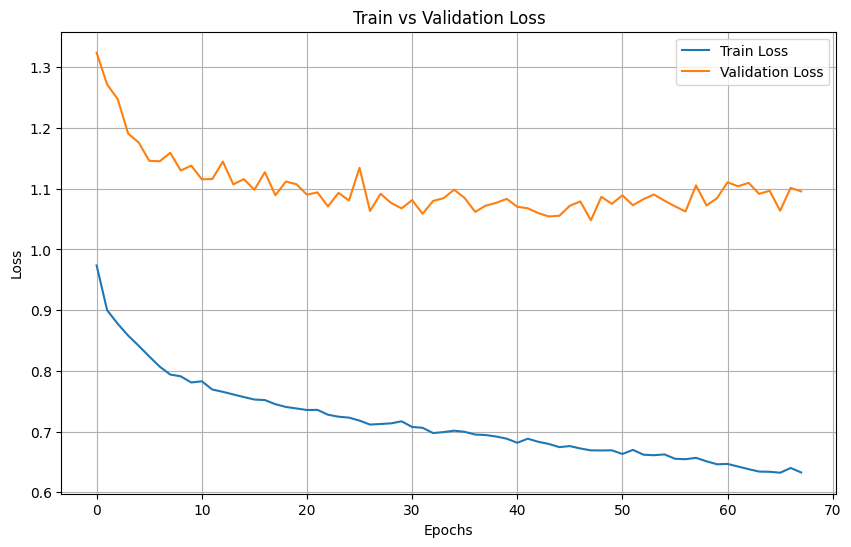

In [421]:
# Crea il grafico delle loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

MAE Swim: 100.30760380109031
 MAE Bike: 272.8214576137601
 MAE Run: 164.43147175205326
 MAE Total: 455.6858552295203
MSE swim: 17633.77486523286
 MSE Bike: 145581.97022833477
 MSE Run: 45811.15328352934
 MSE Total: 435367.2442750439
RMSE Swim: 132.79222441556155
 RMSE Bike: 381.55205441503625
 RMSE Run: 214.03540193979438
 RMSE Total: 659.8236463442666
R2 Swim: -0.05471083288362344
 R2 Bike: -0.3272616693068777
 R2 Run: -0.10509580184215905
 R2 Total: -0.39834419201543714



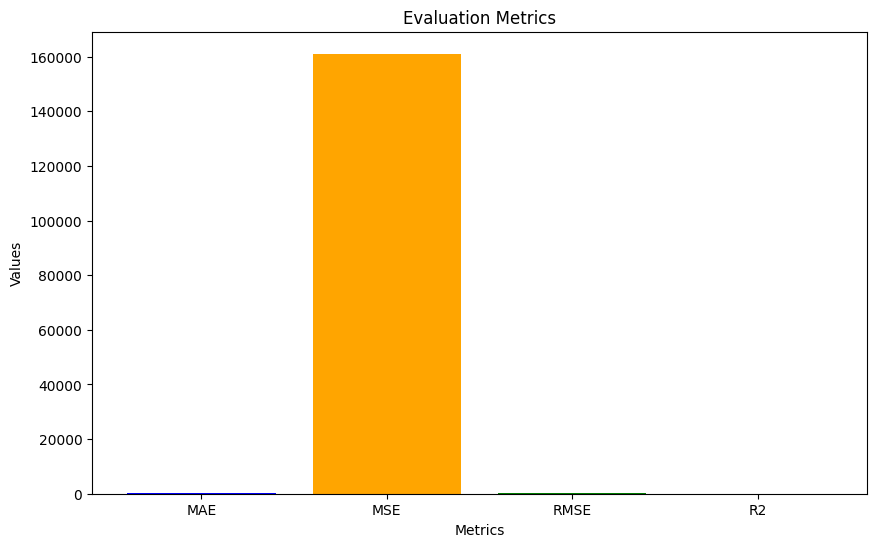

In [422]:
# Predizioni sui dati di validazione
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch in val_loader:
        y_pred = model(X_batch[0])
        y_pred_list.append(y_pred)

y_pred_tensor = torch.cat(y_pred_list, dim=0)
y_pred_numpy = y_pred_tensor.numpy()

# Inverso della trasformazione di scaling
y_pred = scaler_y.inverse_transform(y_pred_numpy)
y_val_inverse = scaler_y.inverse_transform(y_val_scaled)

# Calcolo delle metriche
mae = mean_absolute_error(y_val_inverse, y_pred, multioutput='raw_values')
mse = mean_squared_error(y_val_inverse, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_val_inverse, y_pred, multioutput='raw_values')

print(f'MAE Swim: {mae[0]}\n MAE Bike: {mae[1]}\n MAE Run: {mae[2]}\n MAE Total: {mae[3]}\n\
MSE swim: {mse[0]}\n MSE Bike: {mse[1]}\n MSE Run: {mse[2]}\n MSE Total: {mse[3]}\n\
RMSE Swim: {rmse[0]}\n RMSE Bike: {rmse[1]}\n RMSE Run: {rmse[2]}\n RMSE Total: {rmse[3]}\n\
R2 Swim: {r2[0]}\n R2 Bike: {r2[1]}\n R2 Run: {r2[2]}\n R2 Total: {r2[3]}\n')

# Creazione di un dizionario con le metriche
metrics = {
    'MAE': mae.mean(),
    'MSE': mse.mean(),
    'RMSE': rmse.mean(),
    'R2': r2.mean()
}

# Nomi delle metriche e valori
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red'])

# Aggiunta delle etichette e del titolo
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.show()


In [423]:
# Funzione di conversione da secondi a HH:MM:SS
def second_to_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Esempio di range di giorni per la predizione
min_days = 3
max_days = 4

# Lista per salvare le previsioni future
future_predictions = []

# Itera sui giorni nel range che hai definito
for days in range(min_days, max_days + 1):
    future_features = X_train.iloc[-1:].copy()

    for col in future_features.columns:
        lag = int(col.split('_')[-1])
        if lag <= days:
            future_features[col] = filtered_df.iloc[-1][col.replace(f'_lag_{lag}', '')]
        else:
            future_features[col] = np.nan

    # Aggiungi un piccolo rumore ai dati di input per introdurre variazione
    future_features += np.random.normal(0, 0.01, future_features.shape)

    future_features = future_features.dropna(axis=1, how='all')

    # Verifica se future_features è vuoto o contiene solo NaN
    if future_features.empty or future_features.isnull().all().all():
        print(f"Error: there no value for {days}.")
        continue

    # Scala i dati
    future_features_tensor = torch.tensor(scaler_X.transform(future_features), dtype=torch.float32)

    # Predici i tempi futuri
    model.eval()
    with torch.no_grad():
        future_pred_scaled = model(future_features_tensor)
        future_pred = scaler_y.inverse_transform(future_pred_scaled.numpy())

    # Converti i secondi in HH:MM:SS
    predicted_swim_time = second_to_time(future_pred[0][0])
    predicted_bike_time = second_to_time(future_pred[0][1])
    predicted_run_time = second_to_time(future_pred[0][2])
    predicted_total_time = second_to_time(future_pred[0][3])

    # Aggiungi i risultati nella lista
    future_predictions.append({
        'Day': days,
        'Predicted_swim_time': predicted_swim_time,
        'Predicted_bike_time': predicted_bike_time,
        'Predicted_run_time': predicted_run_time,
        'Predicted_total_time': predicted_total_time
    })

# Converti le previsioni future in un DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Mostra la tabella
future_predictions_df


Day Predicted_swim_time Predicted_bike_time Predicted_run_time  \
0    3            00:20:06            01:00:23           00:36:16   
1    4            00:20:06            01:00:23           00:36:16   

  Predicted_total_time  
0             01:56:32  
1             01:56:32

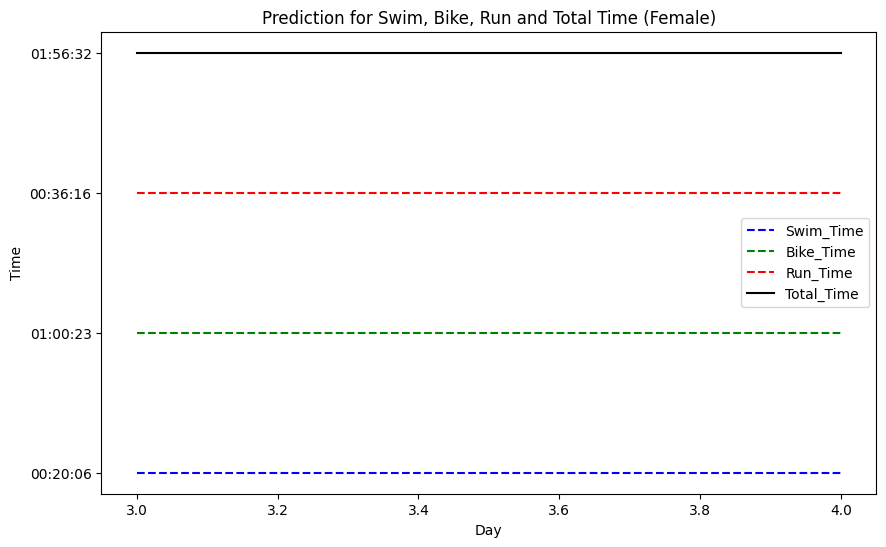

In [417]:
plt.figure(figsize=(10, 6))

# set the line for parameters
plt.plot(future_predictions_df['Day'], future_predictions_df['Predicted_swim_time'], ls="--", color="blue", label='Swim_Time')
plt.plot(future_predictions_df['Day'], future_predictions_df['Predicted_bike_time'], ls="--", color="green" ,label='Bike_Time')
plt.plot(future_predictions_df['Day'], future_predictions_df['Predicted_run_time'], ls="--", color="red", label='Run_Time')
plt.plot(future_predictions_df['Day'], future_predictions_df['Predicted_total_time'], ls="-", color="black", label='Total_Time')

# add labels
plt.xlabel('Day')
plt.ylabel('Time')
plt.title(f'Prediction for Swim, Bike, Run and Total Time {sex}')

# add legend
plt.legend()

plt.show()